import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
# Chicago Car Crashes

## Table Of Contents
<font size=3rem>
    
0 -**[ INTRO](#Introduction)<br>**
1 -**[ OBTAIN](#Obtain)**<br>
2 -**[ SCRUB](#Scrub)**<br>
3 -**[ EXPLORE](#Explore)**<br>
4 -**[ MODEL](#Models)**<br>
5 -**[ INTERPRET](#Interpretations)**<br>
</font>
___

# Introduction
Student: Thomas Cornett

Pace: Self-pace

Instructor: 


In this notebook I am going to be doing a multi-variable classification on the Chicago Car Crash dataset.With this data I will be taking a look at the primary contributory cause of car accidents deemed by Chicago Police. We will be trying to see if the causes of crashes are based off negligent behavior or if it was caused by other means.

## Imports

In [1]:
# import pandas as pd
# import pandas_profiling as pp
# import matplotlib.pyplot as plt
# %matplotlib inline
# import numpy as np
# import seaborn as sns

# from arcgis.gis import GIS
# from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve,roc_curve
from sklearn import tree
from sklearn.metrics import classification_report, multilabel_confusion_matrix,confusion_matrix
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import *
from sklearn.preprocessing import StandardScaler,OrdinalEncoder
import pyforest



### Adjusting settings
Unfortunitly (or not) there is A LOT of data, a little over 471K rows of crash data that we will be sifting through so I am going to adjust some settings first to make it easier to look through. 

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Functions
To make it easier I am going to set and define all the functions that I will be using here for later in the project. 

In [3]:
def get_data():
    crash_data = pd.read_csv('Data\Chicago_car_wrecks.csv')
    vehicle = pd.read_csv('Data\Accidents_vehicles.csv',low_memory = False)
    persons = pd.read_csv('Data\Accidents_people.csv',low_memory = False)
    return crash_data,vehicle,persons

In [4]:
def Cleaning(persons,vehicle,crash_data):
        columns_to_remove = ['RD_NO','UNIT_NO','CMRC_VEH_I','VEHICLE_DEFECT','TRAVEL_DIRECTION','MANEUVER','TOWED_I','FIRE_I',
                            'OCCUPANT_CNT','TOWED_BY','TOWED_TO','AREA_00_I','AREA_01_I','AREA_02_I',
                             'AREA_03_I','AREA_04_I','AREA_05_I','AREA_06_I','AREA_07_I','AREA_08_I','AREA_09_I','AREA_10_I',
                             'AREA_11_I','AREA_12_I','AREA_99_I','FIRST_CONTACT_POINT','CMV_ID','USDOT_NO','CCMC_NO','ILCC_NO',
                            'COMMERCIAL_SRC','GVWR','CARRIER_NAME','CARRIER_STATE','CARRIER_CITY','HAZMAT_PLACARDS_I',
                             'HAZMAT_NAME','UN_NO','HAZMAT_PRESENT_I','HAZMAT_REPORT_I','HAZMAT_REPORT_NO','MCS_REPORT_I',
                             'MCS_REPORT_NO','HAZMAT_VIO_CAUSE_CRASH_I','MCS_VIO_CAUSE_CRASH_I','IDOT_PERMIT_NO','WIDE_LOAD_I',
                             'TRAILER1_WIDTH','TRAILER2_WIDTH','TRAILER1_LENGTH','TRAILER2_LENGTH','HOSPITAL','EMS_AGENCY',
                             'EMS_RUN_NO', 'PEDPEDAL_ACTION','PEDPEDAL_VISIBILITY','PEDPEDAL_LOCATION','INTERSECTION_RELATED_I',
                             'NOT_RIGHT_OF_WAY_I','HIT_AND_RUN_I','CRASH_DATE_EST_I','LANE_CNT',
                             'BEAT_OF_OCCURRENCE','PHOTOS_TAKEN_I','STATEMENTS_TAKEN_I','DOORING_I','WORK_ZONE_I',
                             'WORK_ZONE_TYPE','WORKERS_PRESENT_I', 'INJURIES_TOTAL','INJURIES_FATAL','INJURIES_INCAPACITATING',
                             'INJURIES_NON_INCAPACITATING','INJURIES_REPORTED_NOT_EVIDENT','INJURIES_NO_INDICATION',
                             'INJURIES_UNKNOWN','SEAT_NO',
                             'HAZMAT_OUT_OF_SERVICE_I','MCS_OUT_OF_SERVICE_I','VEHICLE_ID_y','HAZMAT_CLASS',
                             'RD_NO_x','CRASH_DATE_x','VEHICLE_ID_x','RD_NO_y','CRASH_DATE_y','CRASH_UNIT_ID',
                             'TOTAL_VEHICLE_LENGTH','AXLE_CNT','VEHICLE_CONFIG','CARGO_BODY_TYPE','LOAD_TYPE','PERSON_ID',
                             'DRIVERS_LICENSE_CLASS', 'LOCATION', 'PERSON_TYPE', 'VEHICLE_USE']
        crash_data['PRIM_CONTRIBUTORY_CAUSE'] = np.where(crash_data.PRIM_CONTRIBUTORY_CAUSE == 'NOT APPLICABLE',crash_data.SEC_CONTRIBUTORY_CAUSE,crash_data.PRIM_CONTRIBUTORY_CAUSE)
        persons.fillna(persons.dtypes.replace({'int64': 0,'float64':0.0 ,'O': 'UNKNOWN'}), inplace=True)
        vehicle.fillna(vehicle.dtypes.replace({'int64': 0,'float64':0.0 ,'O': 'UNKNOWN'}), inplace=True)
        crash_data.fillna(crash_data.dtypes.replace({'int64': 0,'float64':0.0 ,'O': 'UNKNOWN'}), inplace=True)
        data = pd.merge(crash_data,vehicle, on= 'CRASH_RECORD_ID', how = 'inner')
        full_info = pd.merge(data,persons, on = 'CRASH_RECORD_ID', how = 'inner')
        clean_data = full_info.drop(columns = columns_to_remove).copy()
        clean = clean_data.drop_duplicates(subset=['CRASH_RECORD_ID'], keep='first', inplace=False)
        clean.columns = map(str.title, clean.columns)
        persons.columns = map(str.title, persons.columns)
        vehicle.columns = map(str.title, vehicle.columns)
        crash_data.columns = map(str.title, crash_data.columns)
        clean['Prim_Contributory_Cause'] = clean['Prim_Contributory_Cause'].str.lower()
        clean['Sec_Contributory_Cause'] = clean['Sec_Contributory_Cause'].str.lower()
#         clean['Zipcode'].replace({'UNKNO': '0','J2X5L8':'0'},inplace = True)
#         clean['Zipcode'].str[:5].astype(int).astype(int)
        clean['Num_Passengers'] = clean['Num_Passengers'].astype(int)
        clean['Vehicle_Year'] = clean['Vehicle_Year'].astype(int)
        clean['Latitude'] = clean['Latitude'].astype(float)
        clean['Longitude']= clean['Longitude'].astype(float)
#         clean['Zipcode'] = clean['Zipcode'].astype(int)
        clean['Age'] = clean['Age'].astype(int)
        clean['Day_Of_Week'] = clean['Crash_Day_Of_Week']
        clean['Crash_Day_Of_Week'].replace({1:'Monday',2:'Tuesday',3:'Wednesday',4:'Thursday',5:'Friday',6:'Saturday',7:'Sunday'},inplace = True)
        clean['Crash_Date'] =pd.to_datetime(clean['Crash_Date'])
        clean.drop('Crash_Record_Id',axis = 1,inplace = True)
        clean.fillna(clean.dtypes.replace({'int64': 0,'float64':0.0 ,'O': 'UNKNOWN'}), inplace=True)
        clean['Address']=clean.apply(lambda x:'%s_%s_%s' % (x['Street_No'],x['Street_Direction'],x['Street_Name']),axis=1)
        clean['Address'] = clean['Address'].replace('_',' ', regex = True)
        clean.drop(['Street_No','Street_Direction','Street_Name'], axis = 1, inplace = True)
        clean = featReducing(clean)
        return clean

In [5]:
def Data_fitting(dataset,classification_grouping):
    """Takes a dataset, the amount you want to try and use in the train test split, and what columns you groupings you want
        to test on and outputs the X and y values for train_test_splits""" 
    
    encoder = OrdinalEncoder()
    df = dataset.select_dtypes(object)
    df_num = dataset.select_dtypes(np.number)
    df_cat = df.astype(str)
    data1 = pd.DataFrame(encoder.fit_transform(df_cat), columns = df_cat.columns)
    data1.reset_index(drop=True, inplace=True)
    df_num.reset_index(drop=True, inplace=True)
    data = pd.concat([data1, df_num],axis=1)
    X = data.drop(classification_grouping, axis = 1)
    y = data[classification_grouping]
    
    
    
    return X,y,data
    

In [6]:
def Graph (dataset,x_val,y_val,graphtype,title,y_label,x_label,size):
    """ Graphing made easy.
    dataset: dataset that you are using
    x_val: what you are wanting to graph on the x-axis.| not always needed
    y_val: what you want to graph on the y-axis. | not always needed
    graphtype: set which graph from the bottom list to that dataset. none provided errors out to no graph
    y_label: set the label to the y axis 
    x_label: set the label to the x-axis
    size: size of the plot figure"""
    plt.figure(figsize = size)
    plt.tight_layout()
    if graphtype == 'countplot':
        ax = sns.countplot(x=x_val,y = y_val, data=dataset);
        ax.set_title(title,size = 14);
        ax.set_ylabel(y_label,size = 12);
        ax.set_xlabel(x_label,size = 12);
    elif graphtype == 'scatterplot':
        ax = sns.scatterplot(data=dataset, x= x_val, y=y_val)
        ax.set_title(title,size = 14);
        ax.set_ylabel(y_label,size = 12);
        ax.set_xlabel(x_label,size = 12);
    elif graphtype =='regression':
        ax = sns.lmplot(x=x_val, y=y_val, data=dataset)
        ax.set_title(title,size = 14);
        ax.set_ylabel(y_label,size = 12)
        ax.set_xlabel(x_label,size = 12)
    elif graphtype == 'matrix':
        ax = sns.pairplot(dataset, hue=x_val)
#         ax.set_title(title,size = 14);
#         ax.set_ylabel(y_label,size = 12)
#         ax.set_xlabel(x_label,size = 12)
    elif graphtype == 'violinplot':
        ax = sns.violinplot(x=x_val, y=y_val,
                    data=dataset, palette="muted")
    elif graphtype == 'distplot':
        ax = sns.displot(data= dataset,x = x_val)
    else:
        print('Errored out. no graph subjected to data')

In [7]:
def featReducing(df):
    conditions = [(df['Weather_Condition'] == 'CLEAR') & 
            (df['Lighting_Condition'] == 'DAYLIGHT') & 
            (df['Roadway_Surface_Cond'] == 'DRY') &
            (df['Road_Defect'] == 'NO DEFECTS'),
            (df['Weather_Condition'] == 'RAIN') |(df['Weather_Condition'] =='CLOUDY/OVERCAST') & 
            (df['Lighting_Condition'] == 'DARKNESS') |(df['Lighting_Condition'] == 'DARKNESS, LIGHTED ROAD') & 
            (df['Roadway_Surface_Cond'] == 'WET') &
            (df['Road_Defect'] != 'NO DEFECTS')]


    values = ['Perfect','Not Ideal']
    df['Driving_Condition'] =np.select(conditions,values)

    df['Driving_Condition'].replace({'0':'Hazardous'}, inplace = True)

    df.drop(['Weather_Condition','Lighting_Condition','Roadway_Surface_Cond','Road_Defect'], axis = 1,inplace = True)
    if [(df['Drivers_License_State'] != 'IL') & (df['Lic_Plate_State'] !='IL')]:
        df['Drivers_License'] = 'Out of State'
    else:
        df['Drivers_License'] = 'In State'
    df.drop(['Drivers_License_State','Lic_Plate_State'],axis = 1,inplace = True)
    return df

In [8]:
def featConditioning(data):
    if data['Prim_Contributory_Cause'] in ['operating vehicle in erratic, reckless, careless, negligent or aggressive manner',
                                          'under the influence of alcohol/drugs (use when arrest is effected)',
                                          'had been drinking (use when arrest is not made)','exceeding safe speed for conditions',
                                          'exceeding authorized speed limit','improper overtaking/passing','passing stopped school bus',
                                          'texting','distraction - other electronic device (navigation device, dvd player, etc.)',
                                          'cell phone use other than texting','driving on wrong side/wrong way','improper turning/no signal',
                                          'improper lane usage','following too closely','distraction - from outside vehicle']:
        return 'Negligent'
    
    if data['Prim_Contributory_Cause'] in ['failing to yield right-of-way','motorcycle advancing legally on red light',
                                          'bicycle advancing legally on red light','related to bus stop','disregarding yield sign','turning right on red',
                                          'disregarding road markings','disregarding other traffic signs','physical condition of driver',
                                          'distraction - from inside vehicle','disregarding traffic signals','disregarding stop sign',
                                          'driving skills/knowledge/experience','failing to reduce speed to avoid crash',]:
        return 'Non-negligent'
    
    if data['Prim_Contributory_Cause'] in ['unable to determine','not applicable','animal','evasive action due to animal, object, nonmotorist',
                                           'road construction/maintenance','road engineering/surface/marking defects','vision obscured (signs, tree limbs, buildings, etc.)',
                                          'equipment - vehicle condition','weather','obstructed crosswalks']:
        return 'undetermined'

# Obtain
I will be working with the Chicago Crash Dataset provided by the city of Chicago as part of their Vision Zero plan. It is split up into 3 different datasets: Persons, Vehicle, and Crashes. I am pulling all three of them so that I can get a 'bigger' picture of what it is that could be causing the problem. I am going to link the dataset locations online so it is easier for others to find what I am looking at.

In [9]:
Crashes,Vehicles,Persons = get_data()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
test_data = pd.read_csv('Data/Testing_Data.csv')

<IPython.core.display.Javascript object>

## Initial look through

### Traffic Crashes:
Dataset location: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if


In [11]:
display(Crashes.info())
display(Crashes.head())
Crashes.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471122 entries, 0 to 471121
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                471122 non-null  object 
 1   RD_NO                          467952 non-null  object 
 2   CRASH_DATE_EST_I               35166 non-null   object 
 3   CRASH_DATE                     471122 non-null  object 
 4   POSTED_SPEED_LIMIT             471122 non-null  int64  
 5   TRAFFIC_CONTROL_DEVICE         471122 non-null  object 
 6   DEVICE_CONDITION               471122 non-null  object 
 7   WEATHER_CONDITION              471122 non-null  object 
 8   LIGHTING_CONDITION             471122 non-null  object 
 9   FIRST_CRASH_TYPE               471122 non-null  object 
 10  TRAFFICWAY_TYPE                471122 non-null  object 
 11  LANE_CNT                       198961 non-null  float64
 12  ALIGNMENT                     

None

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION
0,4fd0a3e0897b3335b94cd8d5b2d2b350eb691add56c62d...,JC343143,NaN,07/10/2019 05:56:00 PM,35,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,TURNING,ONE-WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/10/2019 06:16:00 PM,IMPROPER BACKING,UNABLE TO DETERMINE,2158,N,MARMORA AVE,2515.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,17,4,7,41.919664,-87.773288,POINT (-87.773287883007 41.919663832993)
1,009e9e67203442370272e1a13d6ee51a4155dac65e583d...,JA329216,NaN,06/30/2017 04:00:00 PM,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,TURNING,NOT DIVIDED,4.0,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,Y,NaN,NaN,"OVER $1,500",06/30/2017 04:01:00 PM,FAILING TO YIELD RIGHT-OF-WAY,NOT APPLICABLE,8301,S,CICERO AVE,834.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,16,6,6,41.741804,-87.740954,POINT (-87.740953581987 41.741803598989)
2,ee9283eff3a55ac50ee58f3d9528ce1d689b1c4180b4c4...,JD292400,NaN,07/10/2020 10:25:00 AM,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,FOUR WAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/10/2020 10:25:00 AM,FAILING TO YIELD RIGHT-OF-WAY,FAILING TO YIELD RIGHT-OF-WAY,1632,E,67TH ST,331.0,NaN,NaN,NaN,NaN,NaN,NaN,3,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,10,6,7,41.773456,-87.585022,POINT (-87.585022352022 41.773455972008)
3,f8960f698e870ebdc60b521b2a141a5395556bc3704191...,JD293602,NaN,07/11/2020 01:00:00 AM,30,NO CONTROLS,NO CONTROLS,CLEAR,DARKNESS,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,NaN,NaN,Y,$500 OR LESS,07/11/2020 08:30:00 AM,UNABLE TO DETERMINE,UNABLE TO DETERMINE,110,E,51ST ST,224.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1,7,7,41.802119,-87.622115,POINT (-87.622114914961 41.802118543011)
4,8eaa2678d1a127804ee9b8c35ddf7d63d913c14eda61d6...,JD290451,NaN,07/08/2020 02:00:00 PM,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,DRIVEWAY,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,ON SCENE,NO INJURY / DRIVE AWAY,NaN,NaN,NaN,"OVER $1,500",07/08/2020 02:15:00 PM,UNABLE TO DETERMINE,UNABLE TO DETERMINE,412,W,OHARE ST,1654.0,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,4,7,NaN,NaN,NaN


(471122, 49)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

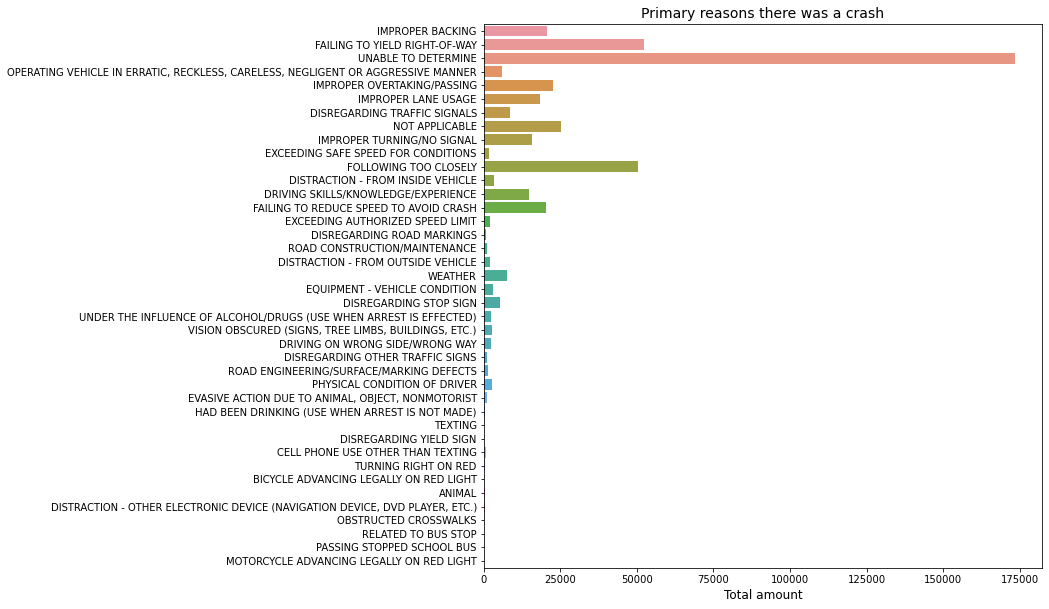

In [12]:

title = 'Primary reasons there was a crash'
y1 = ''
x1 = 'Total amount'
Graph(Crashes,None ,'PRIM_CONTRIBUTORY_CAUSE','countplot',title,y1,x1,(10,10))



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

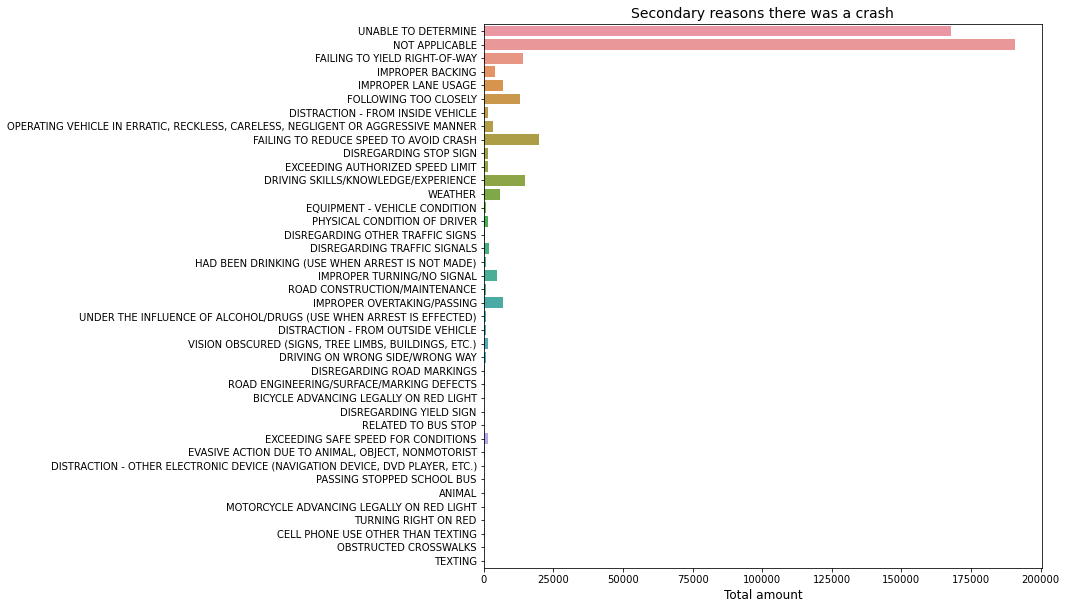

In [13]:
title = 'Secondary reasons there was a crash'
y1 = ''
x1 = 'Total amount'
Graph(Crashes,None ,'SEC_CONTRIBUTORY_CAUSE','countplot',title,y1,x1,(10,10))

### Vehicles:
Dataset Location: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Vehicles/68nd-jvt3

In [14]:
display(Vehicles.info())
Vehicles.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 963888 entries, 0 to 963887
Data columns (total 72 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CRASH_UNIT_ID             963888 non-null  int64  
 1   CRASH_RECORD_ID           963888 non-null  object 
 2   RD_NO                     957106 non-null  object 
 3   CRASH_DATE                963888 non-null  object 
 4   UNIT_NO                   963888 non-null  int64  
 5   UNIT_TYPE                 962443 non-null  object 
 6   NUM_PASSENGERS            144790 non-null  float64
 7   VEHICLE_ID                941455 non-null  float64
 8   CMRC_VEH_I                17882 non-null   object 
 9   MAKE                      941450 non-null  object 
 10  MODEL                     941308 non-null  object 
 11  LIC_PLATE_STATE           862168 non-null  object 
 12  VEHICLE_YEAR              789522 non-null  float64
 13  VEHICLE_DEFECT            941455 non-null  o

None

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS
0,829999,24ddf9fd8542199d832e1c223cc474e5601b356f1d77a6...,JD124535,01/22/2020 06:25:00 AM,1,DRIVER,NaN,796949.0,NaN,INFINITI,UNKNOWN,IL,2017.0,NONE,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,749947,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,1,DRIVER,NaN,834816.0,NaN,HONDA,CIVIC,IL,2016.0,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,749949,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,2,PARKED,NaN,834819.0,NaN,TOYOTA,YARIS,IL,2010.0,NONE,UNKNOWN/NA,PERSONAL,N,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,749950,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,09/28/2019 03:30:00 AM,3,PARKED,NaN,834817.0,NaN,GENERAL MOTORS CORPORATION (GMC),SIERRA,IL,2008.0,UNKNOWN,UNKNOWN/NA,UNKNOWN/NA,N,PARKED,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,ROOF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,871921,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,04/13/2020 10:50:00 PM,2,DRIVER,NaN,827212.0,NaN,BUICK,ENCORE,IL,NaN,NONE,PASSENGER,PERSONAL,W,STRAIGHT AHEAD,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FRONT-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

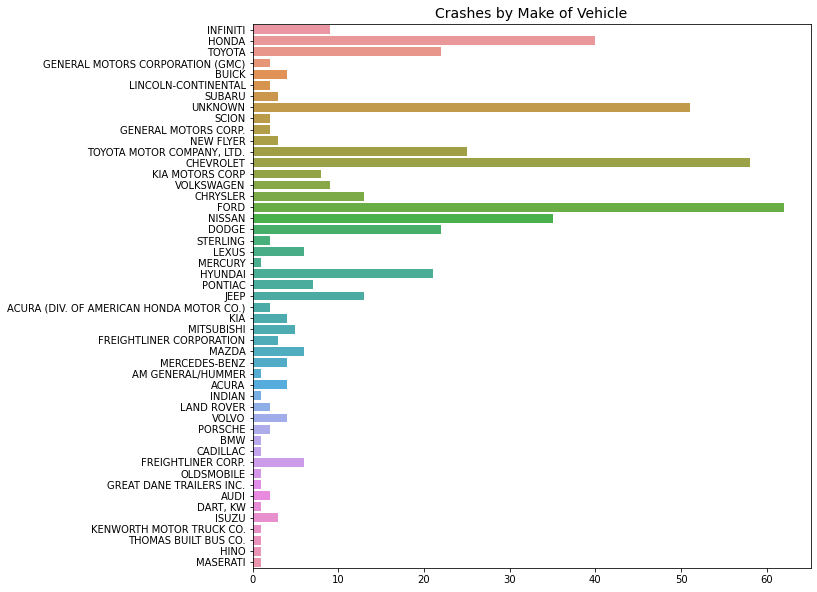

In [15]:
title = 'Crashes by Make of Vehicle'
y1 = ""
x1 = ""
Graph(Vehicles[:500],None,'MAKE','countplot',title,y1,x1,size =(10,10))

### Persons:
Dataset location: https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

In [16]:
display(Persons.head())
Persons.info()

,PERSON_ID,PERSON_TYPE,CRASH_RECORD_ID,RD_NO,VEHICLE_ID,CRASH_DATE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,O749947,DRIVER,81dc0de2ed92aa62baccab641fa377be7feb1cc47e6554...,JC451435,834816.0,09/28/2019 03:30:00 AM,NaN,CHICAGO,IL,60651,M,25.0,IL,D,NONE PRESENT,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,O871921,DRIVER,af84fb5c8d996fcd3aefd36593c3a02e6e7509eeb27568...,JD208731,827212.0,04/13/2020 10:50:00 PM,NaN,CHICAGO,IL,60620,M,37.0,IL,NaN,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
2,O10018,DRIVER,71162af7bf22799b776547132ebf134b5b438dcf3dac6b...,HY484534,9579.0,11/01/2015 05:00:00 AM,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER BACKING,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
3,O10038,DRIVER,c21c476e2ccc41af550b5d858d22aaac4ffc88745a1700...,HY484750,9598.0,11/01/2015 08:00:00 AM,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,O10039,DRIVER,eb390a4c8e114c69488f5fb8a097fe629f5a92fd528cf4...,HY484778,9600.0,11/01/2015 10:15:00 AM,NaN,NaN,NaN,NaN,X,NaN,NaN,NaN,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1045663 entries, 0 to 1045662
Data columns (total 30 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   PERSON_ID              1045663 non-null  object 
 1   PERSON_TYPE            1045663 non-null  object 
 2   CRASH_RECORD_ID        1045663 non-null  object 
 3   RD_NO                  1038665 non-null  object 
 4   VEHICLE_ID             1024792 non-null  float64
 5   CRASH_DATE             1045663 non-null  object 
 6   SEAT_NO                214325 non-null   float64
 7   CITY                   774040 non-null   object 
 8   STATE                  782684 non-null   object 
 9   ZIPCODE                707029 non-null   object 
 10  SEX                    1030159 non-null  object 
 11  AGE                    748528 non-null   float64
 12  DRIVERS_LICENSE_STATE  620287 non-null   object 
 13  DRIVERS_LICENSE_CLASS  539291 non-null   object 
 14  SAFETY_EQUIPMENT  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

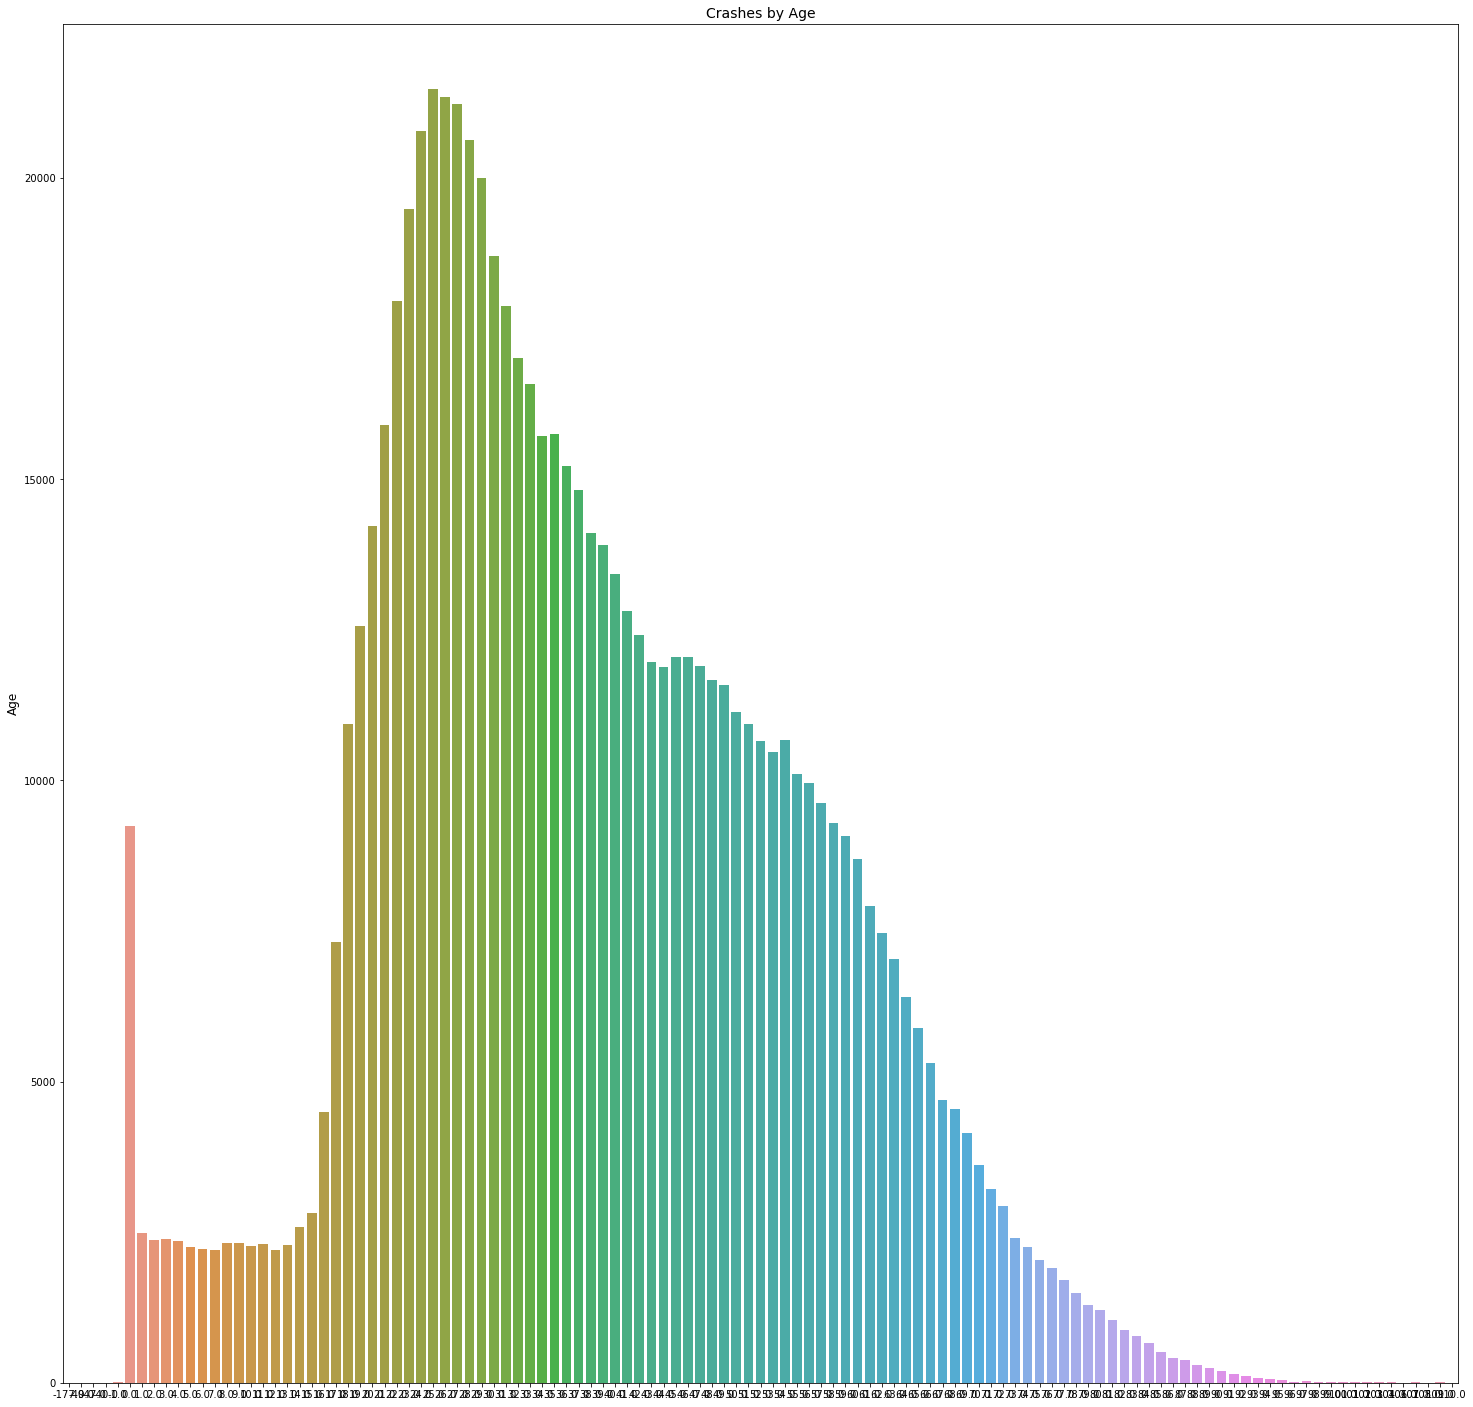

In [17]:

title = 'Crashes by Age'
y1 = 'Age'
x1 = ''
Graph(Persons,"AGE",None,'countplot',title,y1,x1,size =(25,25))

### Initial Observations:
At first glance there is some interesting information that we could possibly use for later. Took a look at some of it but  the data looks pretty broken and missing a lot of data, so let's get to it and clean her up! 

# Scrub
Cleaning the data, getting rid of NaN values, setting them to zeros or UNKNOWN and condensing the dataset down to a more 'managable' level. Started by putting all the cleaning in this section but found it easier to read by putting everything into a function. See Functions section at the top for all cleaning done.

In [18]:
#Pulling out the original information just in case we need it later.
clean = Cleaning(Persons,Vehicles,Crashes)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/p

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Thomas\anaconda3\lib\site-packages\pandas\core\frame.py:4312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\Thomas\anaconda3\lib\site-packages\pandas\core\series.py:4439: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
display(clean.head())
display(clean.info())
# clean['Zipcode']
# clean['Zipcode'] = clean['Zipcode'].replace({'UNKNOWN': '0','J2X5L8':'0','UNK':'0','6 041':'0'})
# clean['Zipcode'].str[:5].astype(int).astype(int)

,Posted_Speed_Limit,Traffic_Control_Device,Device_Condition,First_Crash_Type,Trafficway_Type,Alignment,Report_Type,Crash_Type,Damage,Date_Police_Notified,Prim_Contributory_Cause,Sec_Contributory_Cause,Num_Units,Most_Severe_Injury,Crash_Hour,Crash_Day_Of_Week,Crash_Month,Latitude,Longitude,Unit_Type,Num_Passengers,Make,Model,Vehicle_Year,Vehicle_Type,Exceed_Speed_Limit_I,Crash_Date,City,State,Zipcode,Sex,Age,Safety_Equipment,Airbag_Deployed,Ejection,Injury_Classification,Driver_Action,Driver_Vision,Physical_Condition,Bac_Result,Bac_Result Value,Cell_Phone_Use,Day_Of_Week,Address,Driving_Condition,Drivers_License
0,35,NO CONTROLS,NO CONTROLS,TURNING,ONE-WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2019 06:16:00 PM,improper backing,unable to determine,2,NO INDICATION OF INJURY,17,Thursday,7,41.919664,-87.773288,DRIVER,0,GEO,UNKNOWN,1995,PASSENGER,UNKNOWN,2019-07-10 17:56:00,CHICAGO,IL,60639,M,31,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,IMPROPER BACKING,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,4,2158 N MARMORA AVE,Perfect,Out of State
6,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",06/30/2017 04:01:00 PM,failing to yield right-of-way,not applicable,2,NO INDICATION OF INJURY,16,Saturday,6,41.741804,-87.740954,DRIVER,0,NISSAN,UNKNOWN,2011,SPORT UTILITY VEHICLE (SUV),UNKNOWN,2017-06-30 16:00:00,CHICAGO,IL,UNKNOWN,F,20,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,8301 S CICERO AVE,Perfect,Out of State
12,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,REAR END,FOUR WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2020 10:25:00 AM,failing to yield right-of-way,failing to yield right-of-way,3,NO INDICATION OF INJURY,10,Saturday,7,41.773456,-87.585022,DRIVER,0,TOYOTA,CAMRY,2012,PASSENGER,UNKNOWN,2020-07-10 10:25:00,CHICAGO,IL,60617,M,50,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,1632 E 67TH ST,Perfect,Out of State
21,30,NO CONTROLS,NO CONTROLS,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,$500 OR LESS,07/11/2020 08:30:00 AM,unable to determine,unable to determine,2,NO INDICATION OF INJURY,1,Sunday,7,41.802119,-87.622115,DRIVER,0,TOYOTA,CAMRY,2015,PASSENGER,UNKNOWN,2020-07-11 01:00:00,UNKNOWN,UNKNOWN,UNKNOWN,F,0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,7,110 E 51ST ST,Hazardous,Out of State
27,20,NO CONTROLS,NO CONTROLS,PARKED MOTOR VEHICLE,DRIVEWAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/08/2020 02:15:00 PM,unable to determine,unable to determine,2,NO INDICATION OF INJURY,14,Thursday,7,0.000000,0.000000,DRIVER,0,THOMAS BUILT BUS COMPANY,THOMAS BUILT BUS CO.,2017,BUS OVER 15 PASS.,UNKNOWN,2020-07-08 14:00:00,NEOGA,IL,62447,M,63,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,IMPROPER BACKING,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,4,412 W OHARE ST,Perfect,Out of State


<class 'pandas.core.frame.DataFrame'>
Int64Index: 470172 entries, 0 to 2196030
Data columns (total 46 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Posted_Speed_Limit       470172 non-null  int64         
 1   Traffic_Control_Device   470172 non-null  object        
 2   Device_Condition         470172 non-null  object        
 3   First_Crash_Type         470172 non-null  object        
 4   Trafficway_Type          470172 non-null  object        
 5   Alignment                470172 non-null  object        
 6   Report_Type              470172 non-null  object        
 7   Crash_Type               470172 non-null  object        
 8   Damage                   470172 non-null  object        
 9   Date_Police_Notified     470172 non-null  object        
 10  Prim_Contributory_Cause  470172 non-null  object        
 11  Sec_Contributory_Cause   470172 non-null  object        
 12  Num_Units      

None

In [20]:
clean['Prim_Contributory_Cause'] = clean.apply(lambda data: featConditioning(data), axis=1)


In [21]:
test = clean[(clean.Prim_Contributory_Cause == 'Negligent') | (clean.Prim_Contributory_Cause == 'Non-negligent')]

In [22]:
display(clean.head())
test.head()

,Posted_Speed_Limit,Traffic_Control_Device,Device_Condition,First_Crash_Type,Trafficway_Type,Alignment,Report_Type,Crash_Type,Damage,Date_Police_Notified,Prim_Contributory_Cause,Sec_Contributory_Cause,Num_Units,Most_Severe_Injury,Crash_Hour,Crash_Day_Of_Week,Crash_Month,Latitude,Longitude,Unit_Type,Num_Passengers,Make,Model,Vehicle_Year,Vehicle_Type,Exceed_Speed_Limit_I,Crash_Date,City,State,Zipcode,Sex,Age,Safety_Equipment,Airbag_Deployed,Ejection,Injury_Classification,Driver_Action,Driver_Vision,Physical_Condition,Bac_Result,Bac_Result Value,Cell_Phone_Use,Day_Of_Week,Address,Driving_Condition,Drivers_License
0,35,NO CONTROLS,NO CONTROLS,TURNING,ONE-WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2019 06:16:00 PM,None,unable to determine,2,NO INDICATION OF INJURY,17,Thursday,7,41.919664,-87.773288,DRIVER,0,GEO,UNKNOWN,1995,PASSENGER,UNKNOWN,2019-07-10 17:56:00,CHICAGO,IL,60639,M,31,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,IMPROPER BACKING,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,4,2158 N MARMORA AVE,Perfect,Out of State
6,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",06/30/2017 04:01:00 PM,Non-negligent,not applicable,2,NO INDICATION OF INJURY,16,Saturday,6,41.741804,-87.740954,DRIVER,0,NISSAN,UNKNOWN,2011,SPORT UTILITY VEHICLE (SUV),UNKNOWN,2017-06-30 16:00:00,CHICAGO,IL,UNKNOWN,F,20,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,8301 S CICERO AVE,Perfect,Out of State
12,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,REAR END,FOUR WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2020 10:25:00 AM,Non-negligent,failing to yield right-of-way,3,NO INDICATION OF INJURY,10,Saturday,7,41.773456,-87.585022,DRIVER,0,TOYOTA,CAMRY,2012,PASSENGER,UNKNOWN,2020-07-10 10:25:00,CHICAGO,IL,60617,M,50,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,1632 E 67TH ST,Perfect,Out of State
21,30,NO CONTROLS,NO CONTROLS,PARKED MOTOR VEHICLE,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,$500 OR LESS,07/11/2020 08:30:00 AM,undetermined,unable to determine,2,NO INDICATION OF INJURY,1,Sunday,7,41.802119,-87.622115,DRIVER,0,TOYOTA,CAMRY,2015,PASSENGER,UNKNOWN,2020-07-11 01:00:00,UNKNOWN,UNKNOWN,UNKNOWN,F,0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,7,110 E 51ST ST,Hazardous,Out of State
27,20,NO CONTROLS,NO CONTROLS,PARKED MOTOR VEHICLE,DRIVEWAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/08/2020 02:15:00 PM,undetermined,unable to determine,2,NO INDICATION OF INJURY,14,Thursday,7,0.000000,0.000000,DRIVER,0,THOMAS BUILT BUS COMPANY,THOMAS BUILT BUS CO.,2017,BUS OVER 15 PASS.,UNKNOWN,2020-07-08 14:00:00,NEOGA,IL,62447,M,63,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,IMPROPER BACKING,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,4,412 W OHARE ST,Perfect,Out of State


,Posted_Speed_Limit,Traffic_Control_Device,Device_Condition,First_Crash_Type,Trafficway_Type,Alignment,Report_Type,Crash_Type,Damage,Date_Police_Notified,Prim_Contributory_Cause,Sec_Contributory_Cause,Num_Units,Most_Severe_Injury,Crash_Hour,Crash_Day_Of_Week,Crash_Month,Latitude,Longitude,Unit_Type,Num_Passengers,Make,Model,Vehicle_Year,Vehicle_Type,Exceed_Speed_Limit_I,Crash_Date,City,State,Zipcode,Sex,Age,Safety_Equipment,Airbag_Deployed,Ejection,Injury_Classification,Driver_Action,Driver_Vision,Physical_Condition,Bac_Result,Bac_Result Value,Cell_Phone_Use,Day_Of_Week,Address,Driving_Condition,Drivers_License
6,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",06/30/2017 04:01:00 PM,Non-negligent,not applicable,2,NO INDICATION OF INJURY,16,Saturday,6,41.741804,-87.740954,DRIVER,0,NISSAN,UNKNOWN,2011,SPORT UTILITY VEHICLE (SUV),UNKNOWN,2017-06-30 16:00:00,CHICAGO,IL,UNKNOWN,F,20,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,8301 S CICERO AVE,Perfect,Out of State
12,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,REAR END,FOUR WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2020 10:25:00 AM,Non-negligent,failing to yield right-of-way,3,NO INDICATION OF INJURY,10,Saturday,7,41.773456,-87.585022,DRIVER,0,TOYOTA,CAMRY,2012,PASSENGER,UNKNOWN,2020-07-10 10:25:00,CHICAGO,IL,60617,M,50,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,1632 E 67TH ST,Perfect,Out of State
37,30,NO CONTROLS,NO CONTROLS,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,$500 OR LESS,07/10/2020 10:20:00 PM,Negligent,not applicable,2,NONINCAPACITATING INJURY,22,Saturday,7,41.880386,-87.725807,DRIVER,0,YAMAHA,YAMAHA,2018,MOTORCYCLE (OVER 150CC),UNKNOWN,2020-07-10 22:20:00,ST. CHARLES,IL,60175,M,26,DOT COMPLIANT MOTORCYCLE HELMET,NOT APPLICABLE,NONE,NONINCAPACITATING INJURY,EVADING POLICE VEHICLE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,10 S PULASKI RD,Hazardous,Out of State
45,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",08/30/2018 05:58:00 PM,Negligent,improper lane usage,2,NO INDICATION OF INJURY,17,Friday,8,41.903825,-87.643286,DRIVER,0,FORD,FLEX,2017,PASSENGER,UNKNOWN,2018-08-30 17:45:00,EVANSTON,IL,60201,M,44,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NONE,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,5,600 W DIVISION ST,Hazardous,Out of State
59,30,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,$500 OR LESS,07/10/2020 05:06:00 AM,Negligent,not applicable,2,NO INDICATION OF INJURY,4,Saturday,7,41.886769,-87.745356,DRIVER,0,MAZDA,OTHER (EXPLAIN IN NARRATIVE),0,PASSENGER,UNKNOWN,2020-07-10 04:50:00,UNKNOWN,UNKNOWN,UNKNOWN,X,0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,IMPROPER PASSING,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,351 N CICERO AVE,Hazardous,Out of State


In [23]:
clean.to_csv('E:\Schoolwork\Flat Iron\Classwork\Module 3\Project\Phase-3-project\Data\Cleaned_Data.csv')
test.to_csv('E:\Schoolwork\Flat Iron\Classwork\Module 3\Project\Phase-3-project\Data\Testing_Data.csv')

# Explore
Now that everything is prepped and edited it is time to get nitty gritty with the data and take a look at whats under the hood!

In [24]:
# going to first take a look at the Pandas profiling report to see what the data looks like
# pp.ProfileReport(clean)

### Pulling the testing data after the cleaning

In [25]:
test_data = pd.read_csv('Data/Testing_Data.csv')

<IPython.core.display.Javascript object>

In [26]:
test_data.head()

,Unnamed: 0,Posted_Speed_Limit,Traffic_Control_Device,Device_Condition,First_Crash_Type,Trafficway_Type,Alignment,Report_Type,Crash_Type,Damage,Date_Police_Notified,Prim_Contributory_Cause,Sec_Contributory_Cause,Num_Units,Most_Severe_Injury,Crash_Hour,Crash_Day_Of_Week,Crash_Month,Latitude,Longitude,Unit_Type,Num_Passengers,Make,Model,Vehicle_Year,Vehicle_Type,Exceed_Speed_Limit_I,Crash_Date,City,State,Zipcode,Sex,Age,Safety_Equipment,Airbag_Deployed,Ejection,Injury_Classification,Driver_Action,Driver_Vision,Physical_Condition,Bac_Result,Bac_Result Value,Cell_Phone_Use,Day_Of_Week,Address,Driving_Condition,Drivers_License
0,6,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",06/30/2017 04:01:00 PM,Non-negligent,not applicable,2,NO INDICATION OF INJURY,16,Saturday,6,41.741804,-87.740954,DRIVER,0,NISSAN,UNKNOWN,2011,SPORT UTILITY VEHICLE (SUV),UNKNOWN,2017-06-30 16:00:00,CHICAGO,IL,UNKNOWN,F,20,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,8301 S CICERO AVE,Perfect,Out of State
1,12,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,REAR END,FOUR WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2020 10:25:00 AM,Non-negligent,failing to yield right-of-way,3,NO INDICATION OF INJURY,10,Saturday,7,41.773456,-87.585022,DRIVER,0,TOYOTA,CAMRY,2012,PASSENGER,UNKNOWN,2020-07-10 10:25:00,CHICAGO,IL,60617,M,50,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,1632 E 67TH ST,Perfect,Out of State
2,37,30,NO CONTROLS,NO CONTROLS,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,$500 OR LESS,07/10/2020 10:20:00 PM,Negligent,not applicable,2,NONINCAPACITATING INJURY,22,Saturday,7,41.880386,-87.725807,DRIVER,0,YAMAHA,YAMAHA,2018,MOTORCYCLE (OVER 150CC),UNKNOWN,2020-07-10 22:20:00,ST. CHARLES,IL,60175,M,26,DOT COMPLIANT MOTORCYCLE HELMET,NOT APPLICABLE,NONE,NONINCAPACITATING INJURY,EVADING POLICE VEHICLE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,10 S PULASKI RD,Hazardous,Out of State
3,45,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",08/30/2018 05:58:00 PM,Negligent,improper lane usage,2,NO INDICATION OF INJURY,17,Friday,8,41.903825,-87.643286,DRIVER,0,FORD,FLEX,2017,PASSENGER,UNKNOWN,2018-08-30 17:45:00,EVANSTON,IL,60201,M,44,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NONE,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,5,600 W DIVISION ST,Hazardous,Out of State
4,59,30,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,$500 OR LESS,07/10/2020 05:06:00 AM,Negligent,not applicable,2,NO INDICATION OF INJURY,4,Saturday,7,41.886769,-87.745356,DRIVER,0,MAZDA,OTHER (EXPLAIN IN NARRATIVE),0,PASSENGER,UNKNOWN,2020-07-10 04:50:00,UNKNOWN,UNKNOWN,UNKNOWN,X,0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,IMPROPER PASSING,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,351 N CICERO AVE,Hazardous,Out of State


In [27]:
clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 470172 entries, 0 to 2196030
Data columns (total 46 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Posted_Speed_Limit       470172 non-null  int64         
 1   Traffic_Control_Device   470172 non-null  object        
 2   Device_Condition         470172 non-null  object        
 3   First_Crash_Type         470172 non-null  object        
 4   Trafficway_Type          470172 non-null  object        
 5   Alignment                470172 non-null  object        
 6   Report_Type              470172 non-null  object        
 7   Crash_Type               470172 non-null  object        
 8   Damage                   470172 non-null  object        
 9   Date_Police_Notified     470172 non-null  object        
 10  Prim_Contributory_Cause  449485 non-null  object        
 11  Sec_Contributory_Cause   470172 non-null  object        
 12  Num_Units      

In [28]:
test_data.head()

,Unnamed: 0,Posted_Speed_Limit,Traffic_Control_Device,Device_Condition,First_Crash_Type,Trafficway_Type,Alignment,Report_Type,Crash_Type,Damage,Date_Police_Notified,Prim_Contributory_Cause,Sec_Contributory_Cause,Num_Units,Most_Severe_Injury,Crash_Hour,Crash_Day_Of_Week,Crash_Month,Latitude,Longitude,Unit_Type,Num_Passengers,Make,Model,Vehicle_Year,Vehicle_Type,Exceed_Speed_Limit_I,Crash_Date,City,State,Zipcode,Sex,Age,Safety_Equipment,Airbag_Deployed,Ejection,Injury_Classification,Driver_Action,Driver_Vision,Physical_Condition,Bac_Result,Bac_Result Value,Cell_Phone_Use,Day_Of_Week,Address,Driving_Condition,Drivers_License
0,6,35,STOP SIGN/FLASHER,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",06/30/2017 04:01:00 PM,Non-negligent,not applicable,2,NO INDICATION OF INJURY,16,Saturday,6,41.741804,-87.740954,DRIVER,0,NISSAN,UNKNOWN,2011,SPORT UTILITY VEHICLE (SUV),UNKNOWN,2017-06-30 16:00:00,CHICAGO,IL,UNKNOWN,F,20,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,8301 S CICERO AVE,Perfect,Out of State
1,12,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,REAR END,FOUR WAY,STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,"OVER $1,500",07/10/2020 10:25:00 AM,Non-negligent,failing to yield right-of-way,3,NO INDICATION OF INJURY,10,Saturday,7,41.773456,-87.585022,DRIVER,0,TOYOTA,CAMRY,2012,PASSENGER,UNKNOWN,2020-07-10 10:25:00,CHICAGO,IL,60617,M,50,USAGE UNKNOWN,NOT APPLICABLE,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,1632 E 67TH ST,Perfect,Out of State
2,37,30,NO CONTROLS,NO CONTROLS,SIDESWIPE OPPOSITE DIRECTION,NOT DIVIDED,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,$500 OR LESS,07/10/2020 10:20:00 PM,Negligent,not applicable,2,NONINCAPACITATING INJURY,22,Saturday,7,41.880386,-87.725807,DRIVER,0,YAMAHA,YAMAHA,2018,MOTORCYCLE (OVER 150CC),UNKNOWN,2020-07-10 22:20:00,ST. CHARLES,IL,60175,M,26,DOT COMPLIANT MOTORCYCLE HELMET,NOT APPLICABLE,NONE,NONINCAPACITATING INJURY,EVADING POLICE VEHICLE,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,6,10 S PULASKI RD,Hazardous,Out of State
3,45,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,TURNING,NOT DIVIDED,STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",08/30/2018 05:58:00 PM,Negligent,improper lane usage,2,NO INDICATION OF INJURY,17,Friday,8,41.903825,-87.643286,DRIVER,0,FORD,FLEX,2017,PASSENGER,UNKNOWN,2018-08-30 17:45:00,EVANSTON,IL,60201,M,44,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NONE,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,5,600 W DIVISION ST,Hazardous,Out of State
4,59,30,UNKNOWN,UNKNOWN,SIDESWIPE SAME DIRECTION,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,$500 OR LESS,07/10/2020 05:06:00 AM,Negligent,not applicable,2,NO INDICATION OF INJURY,4,Saturday,7,41.886769,-87.745356,DRIVER,0,MAZDA,OTHER (EXPLAIN IN NARRATIVE),0,PASSENGER,UNKNOWN,2020-07-10 04:50:00,UNKNOWN,UNKNOWN,UNKNOWN,X,0,USAGE UNKNOWN,DEPLOYMENT UNKNOWN,UNKNOWN,NO INDICATION OF INJURY,IMPROPER PASSING,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,351 N CICERO AVE,Hazardous,Out of State


Checking the entire dataset to see how my data stacks up with each other. seeing if there is any type of commonality with anything

<IPython.core.display.Javascript object>

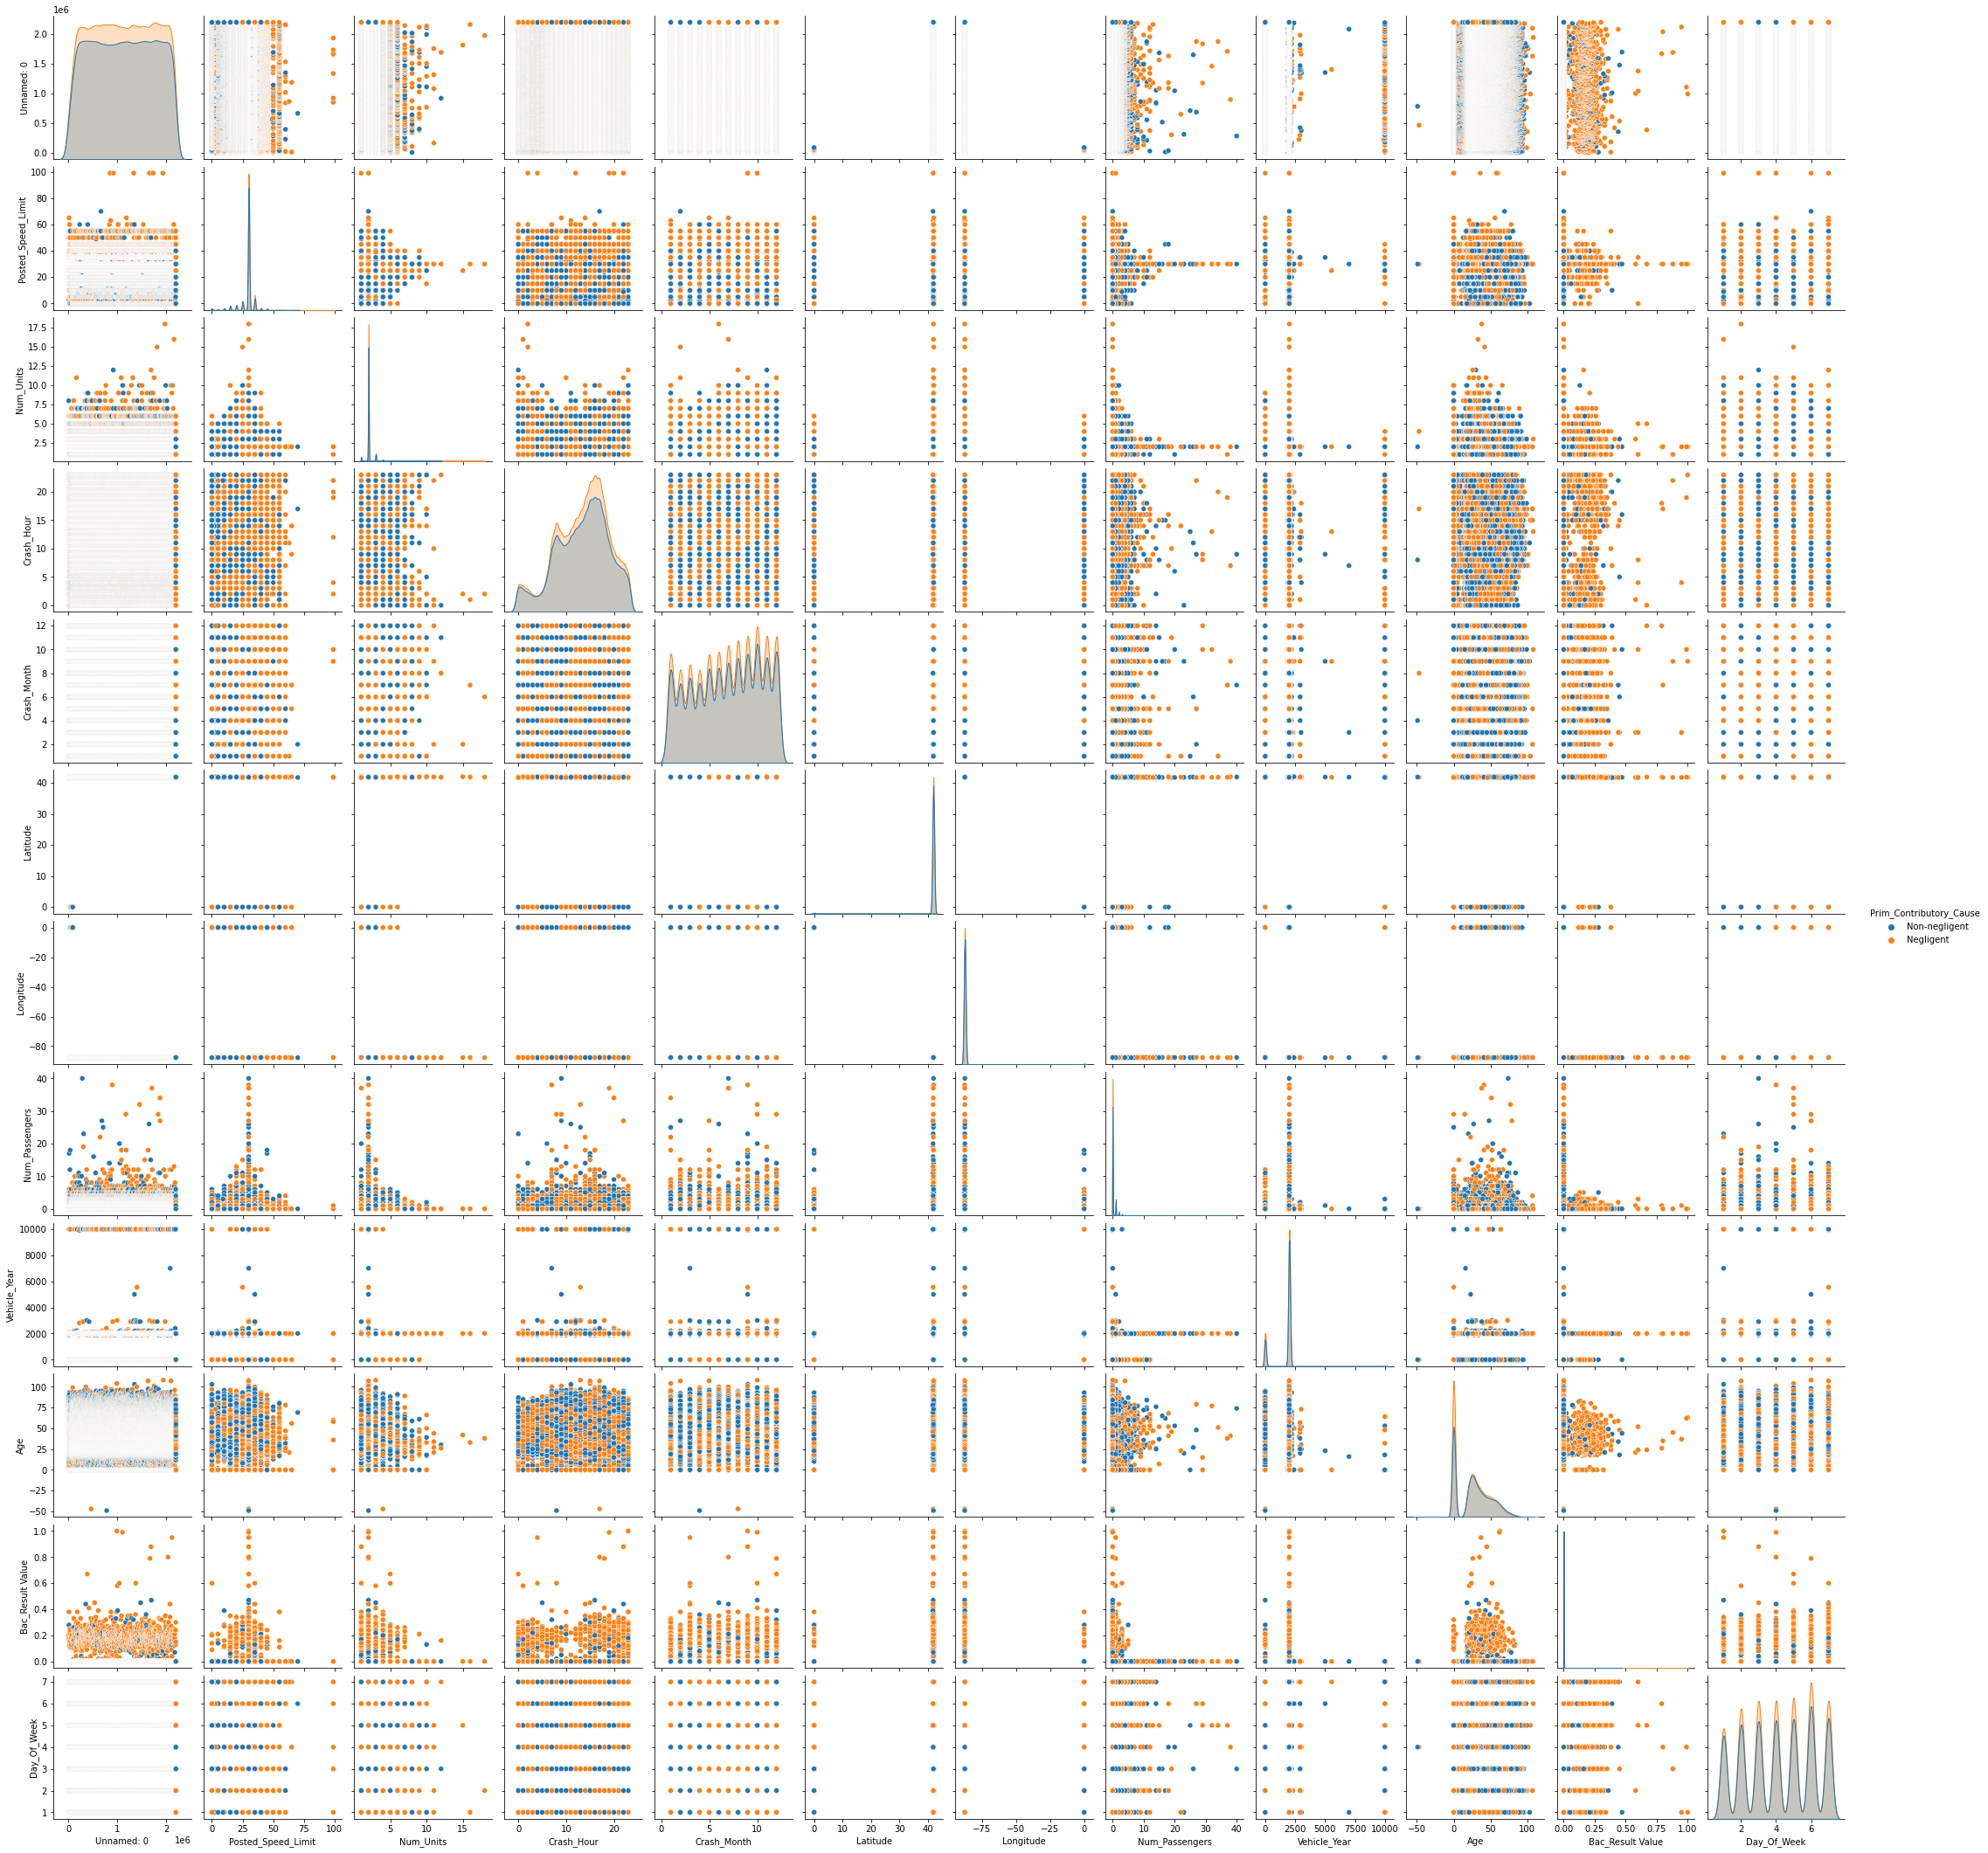

In [29]:
sns.pairplot(test_data, hue="Prim_Contributory_Cause")

### Class Imbalance?
I am looking to see if there is any sort of possible class imbalance. if there is then than the model will have a real difficult time trying to determine if the driver was negligent or not. I am going to first remove the undertermined data out of the cleaned data. 

In [30]:
final_df = test_data[test_data['Prim_Contributory_Cause'] != 'undetermined']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

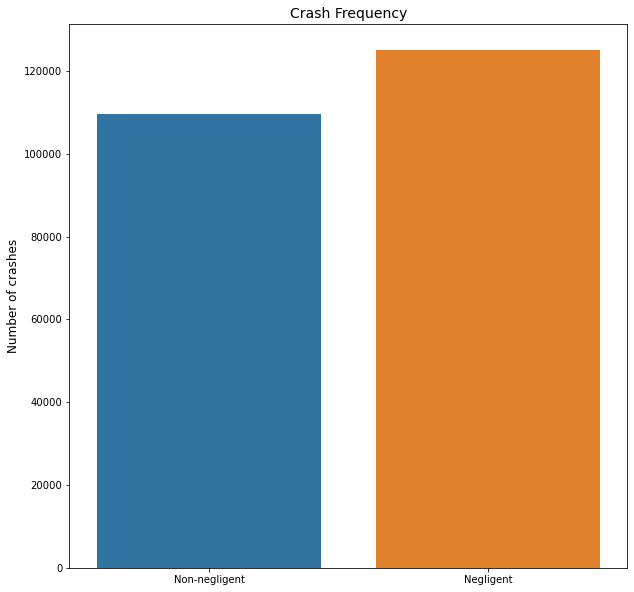

In [31]:
title = 'Crash Frequency'
y1 = 'Number of crashes'
x1 = ''
Graph(final_df, 'Prim_Contributory_Cause',None,'countplot',title,y1,x1,(10,10))

As you can see there is a class imbalance in this dataset. How I am going to do to fix that is take a sample of the dataset at 5,000 data points. The reason I am going with 5,000 instead of more is so my model will have enough data to be able to classify and wont take a long time to predict and run through. I will be saving that to a csv file as Training_Data for use in the model.

In [32]:
Negligent = final_df[final_df['Prim_Contributory_Cause'] == 'Negligent'].copy()
non_negligent = final_df[final_df['Prim_Contributory_Cause'] =='Non-negligent'].copy()
df = non_negligent.sample(10000,random_state = 100)
df2 = Negligent.sample(10000, random_state = 100)
final = pd.concat([df,df2],join = 'inner')

final.to_csv('E:\Schoolwork\Flat Iron\Classwork\Module 3\Project\Phase-3-project\Data\Training_Data.csv')

<IPython.core.display.Javascript object>

### What days are the most crashes to occur


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

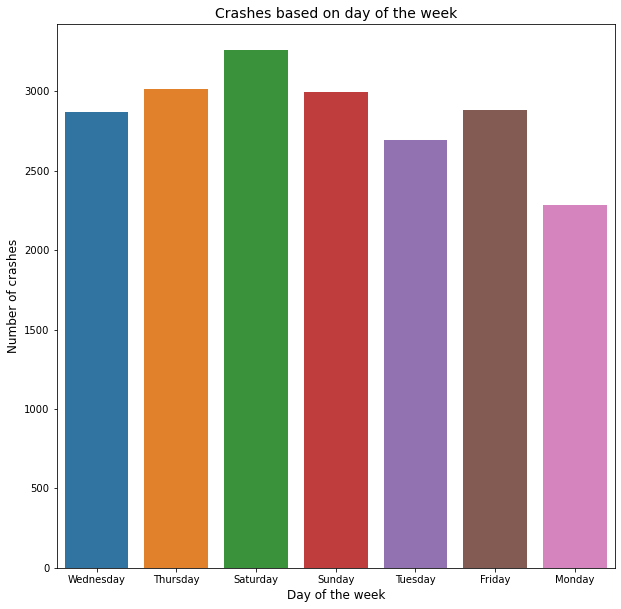

In [33]:

title = 'Crashes based on day of the week'
y1 = 'Number of crashes'
x1 = 'Day of the week'
Graph(final, 'Crash_Day_Of_Week',None,'countplot',title,y1,x1,(10,10))
# ax = sns.violinplot(x="Crash_Day_Of_Week"., y="Prim_Contributory_Cause", #hue="smoker",
#                     data=test_data, palette="muted")

### What time is the most crashes to occur
Crash time is based off of military time

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Thomas\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

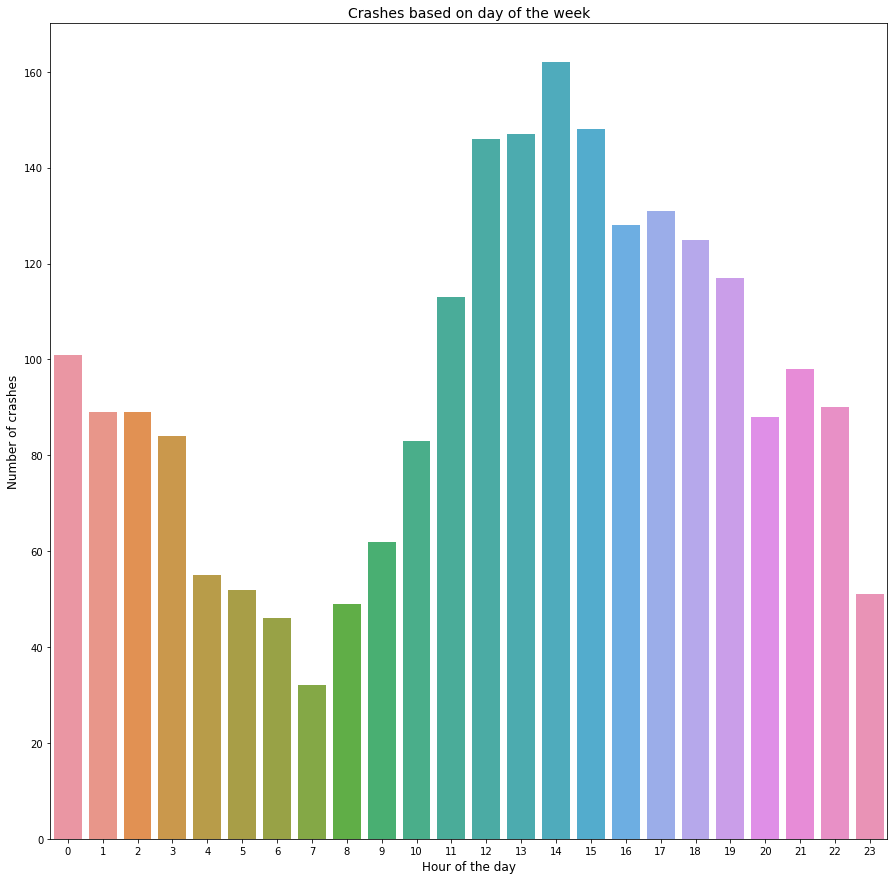

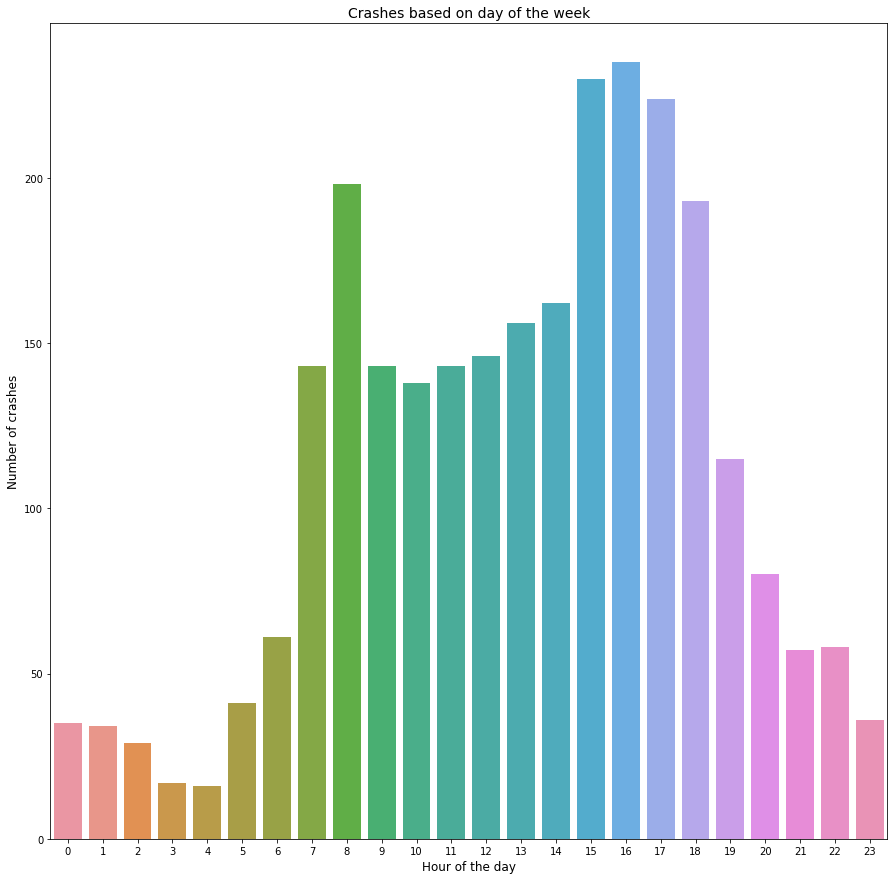

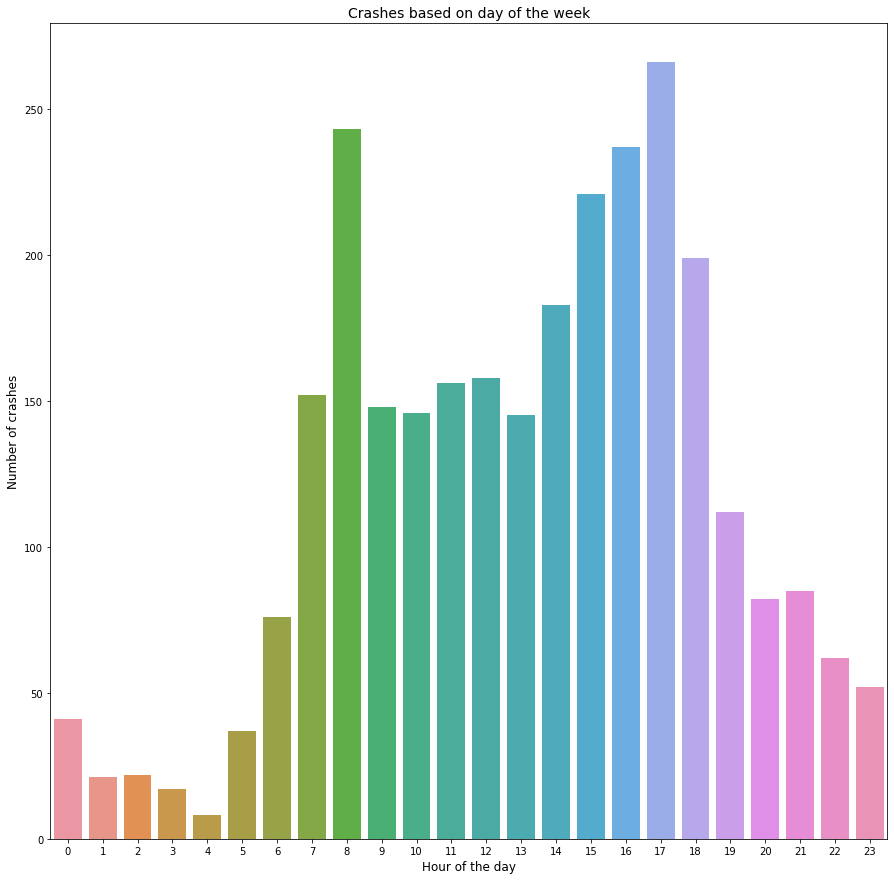

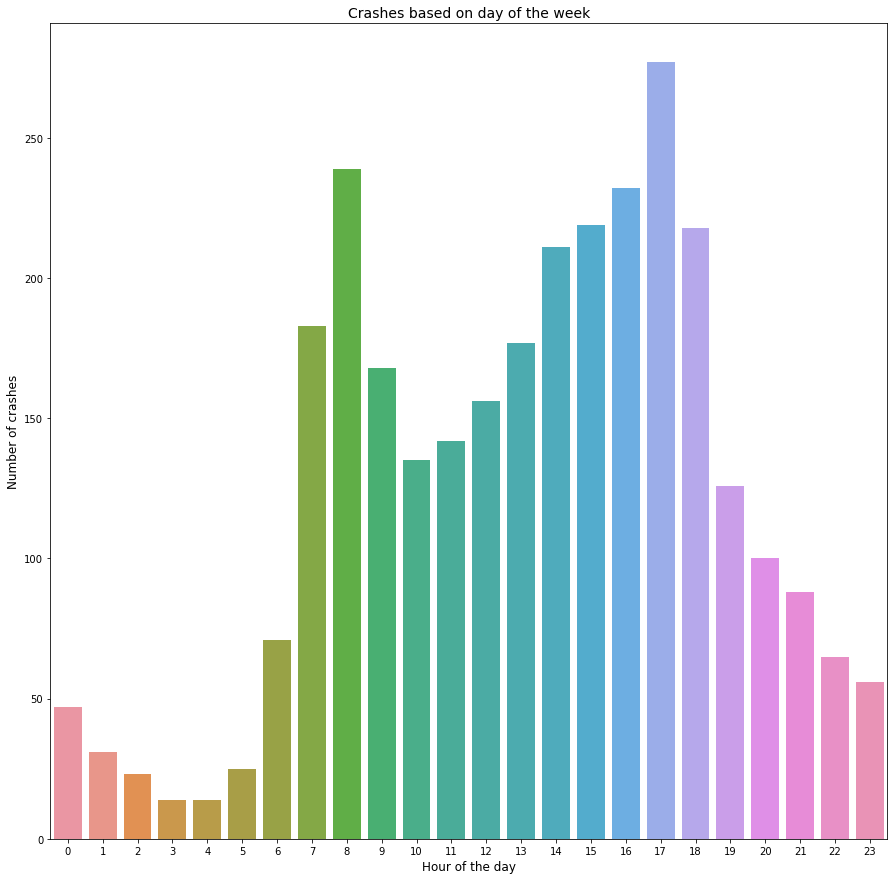

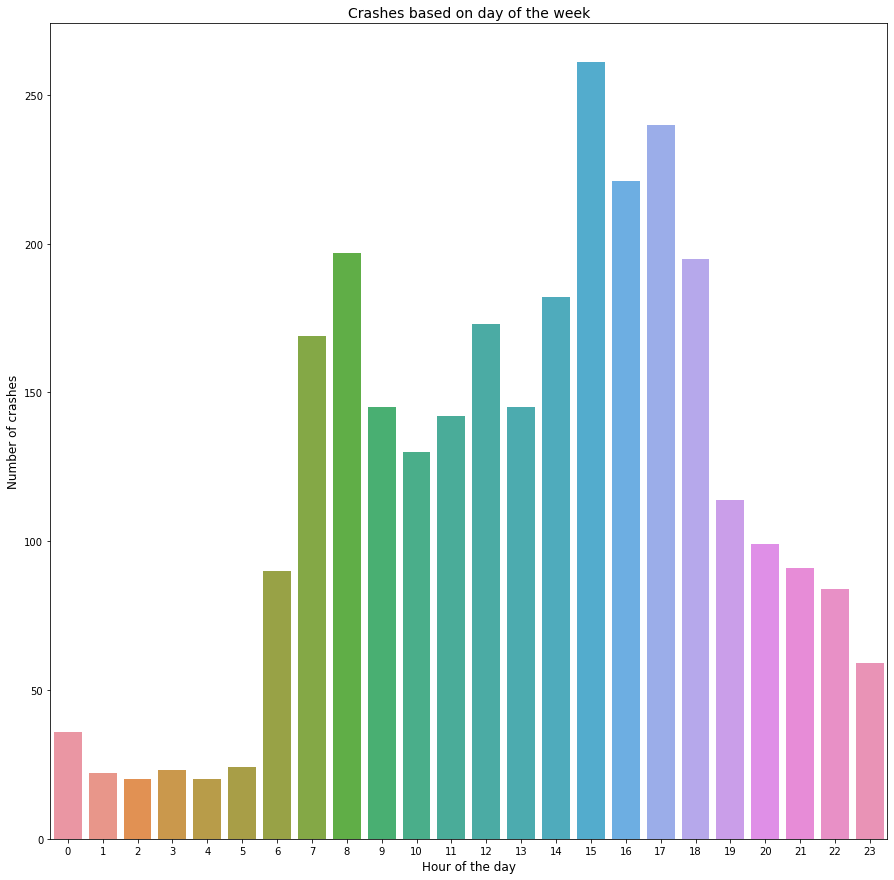

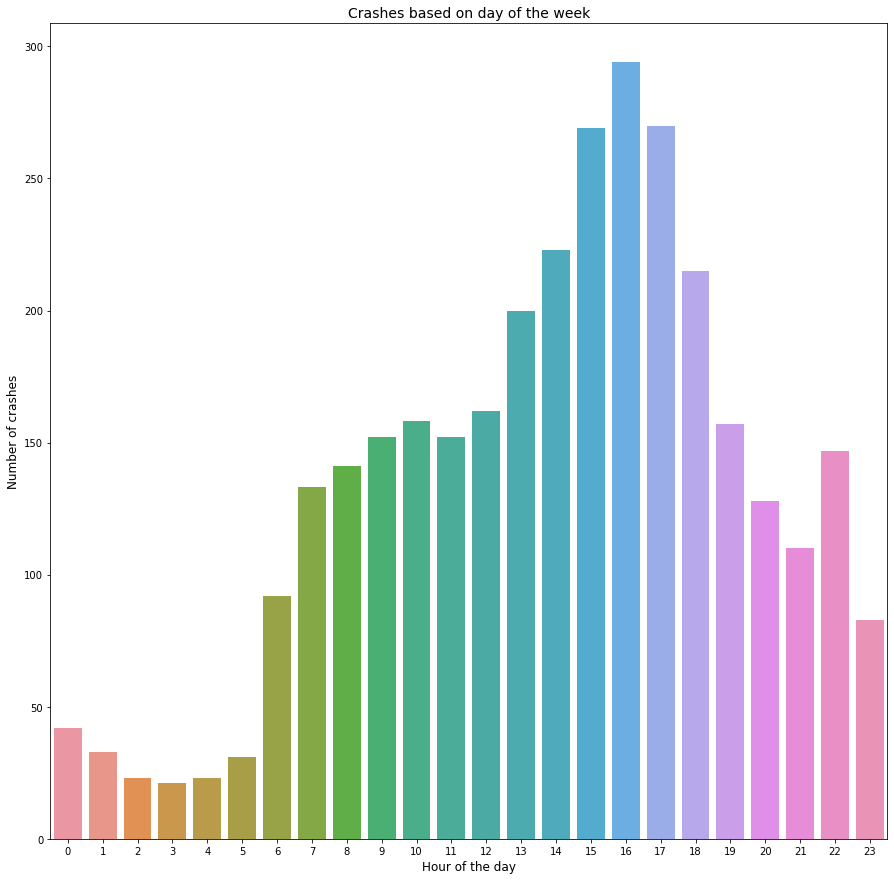

In [34]:
title = 'Crashes based on day of the week'
y1 = 'Number of crashes'
x1 = 'Hour of the day'
for i in range(1,7):
    Graph(final[test_data.Day_Of_Week == i], 'Crash_Hour',None,'countplot',title,y1,x1,(15,15))
    

From the looks of this graph it looks like most of the main crashes are based around the usual morning and afternoon commute

### Crashes by Age
Now lets take a look at the age ranges and see if age could be a decent factor to look at

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1440x1440 with 0 Axes>

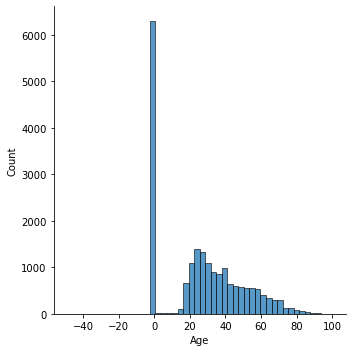

In [35]:
title = 'Crashes based on Age'
y1 = 'Number of crashes'
x1 = ''
Graph(final, 'Age',None,'distplot',title,y1,x1, size = (20,20))

Looks really bad like this and very skewed. In EDA we went ahead and took all nulls and missing values and set them to zero cause we could use this section. Will limit the ages to a range of 16 (getting a permit) and 90 (rough age people stop driving)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 1440x1440 with 0 Axes>

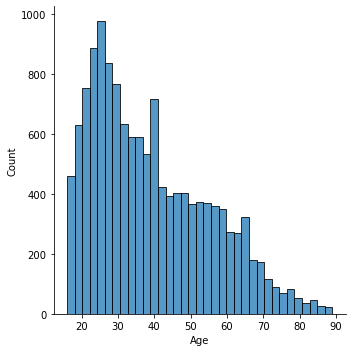

In [36]:
age_data = final[(final.Age >=16) & (final.Age < 90)]
title = 'Crashes based on Age'
y1 = 'Number of crashes'
x1 = ''
Graph(age_data, 'Age',None,'distplot',title,y1,x1, size = (20,20))

### Location of most crash sites
Lets take a quick look at the locations of the top 25 places that the crashes are most common. There are over 150k unique crash addresses so we are just going to take a look a few of those places to get an idea of where they could be located.

In [37]:
n = 25
address_top_25 = final['Address'].value_counts()[:n].index.tolist()


In [38]:
address_list = test_data[(test_data.Address.isin(address_top_25))].copy()
address_list.drop_duplicates(subset=['Address'], keep='first', inplace=True)

In [39]:
# from arcgis import GIS
# gis = GIS("http://www.arcgis.com/", "shadowsword_0","Acidblade1")
# mapp = gis.map('Chicago')
# addresses = pd.DataFrame.spatial.from_xy(address_list,'Longitude','Latitude')
# addresses.spatial.plot(map_widget=mapp, renderer_type = "s", marker_size = 5,
#                           symbol_type='simple',symbol_style='d', # d - for diamonds
#                           colors='Reds_r',
#                           cstep=10,
#                           outline_color='Blues',
#                           renderer = 'ClassedSizeRenderer')

# mapp

Just taking a quick look at this shows me that the most of the places the crashes occur are on or around the interstates and highways. That is to be expected though given the previous notice of the times the crashes occur. It also is not surprising that some of the reasons for these top 25 having a result of reckless driving and drunk driving is based off the age graph

# Model
Let's take a look more into the classification aspect of what it is we are doing and run it through the Random Forest machine learning algorithm and give recommendations on what we should do after that. We will be basing our Train Test Split off of the PRIMARY CONTRIBUTORY CAUSES

## Train Test Split setup


In [40]:
data = pd.read_csv('Data/Training_Data.csv')
X,y,dataset = Data_fitting(data,'Prim_Contributory_Cause')
dataset.head()
data.drop(['Unnamed: 0','Unnamed: 0.1'],axis = 1, inplace = True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [41]:
data.head()


,Posted_Speed_Limit,Traffic_Control_Device,Device_Condition,First_Crash_Type,Trafficway_Type,Alignment,Report_Type,Crash_Type,Damage,Date_Police_Notified,Prim_Contributory_Cause,Sec_Contributory_Cause,Num_Units,Most_Severe_Injury,Crash_Hour,Crash_Day_Of_Week,Crash_Month,Latitude,Longitude,Unit_Type,Num_Passengers,Make,Model,Vehicle_Year,Vehicle_Type,Exceed_Speed_Limit_I,Crash_Date,City,State,Zipcode,Sex,Age,Safety_Equipment,Airbag_Deployed,Ejection,Injury_Classification,Driver_Action,Driver_Vision,Physical_Condition,Bac_Result,Bac_Result Value,Cell_Phone_Use,Day_Of_Week,Address,Driving_Condition,Drivers_License
0,40,NO CONTROLS,NO CONTROLS,OTHER OBJECT,DIVIDED - W/MEDIAN BARRIER,"CURVE, LEVEL",ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",01/01/2019 04:10:00 PM,Non-negligent,weather,1,NO INDICATION OF INJURY,16,Wednesday,1,41.952399,-87.644733,DRIVER,0,HONDA,CRV,2006,PASSENGER,UNKNOWN,2019-01-01 16:05:00,CHICAGO,IL,60645,M,22,SAFETY BELT USED,"DEPLOYED, COMBINATION",NONE,NO INDICATION OF INJURY,TOO FAST FOR CONDITIONS,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,3,3800 N LAKE SHORE DR NB,Hazardous,Out of State
1,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,PEDESTRIAN,DIVIDED - W/MEDIAN (NOT RAISED),STRAIGHT AND LEVEL,ON SCENE,NO INJURY / DRIVE AWAY,$500 OR LESS,01/25/2017 08:17:00 AM,Non-negligent,failing to reduce speed to avoid crash,2,NO INDICATION OF INJURY,8,Thursday,1,41.874229,-87.671625,DRIVER,0,FORD,EXPLORER,2000,PASSENGER,UNKNOWN,2017-01-25 08:16:00,CHICAGO,IL,60609,M,48,SAFETY BELT USED,DID NOT DEPLOY,TOTALLY EJECTED,NO INDICATION OF INJURY,FAILED TO YIELD,NOT OBSCURED,NORMAL,TEST NOT OFFERED,0.0,UNKNOWN,4,1800 W HARRISON ST,Hazardous,Out of State
2,35,NO CONTROLS,NO CONTROLS,ANGLE,UNKNOWN,STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",04/17/2020 01:25:00 PM,Non-negligent,failing to yield right-of-way,2,NO INDICATION OF INJURY,13,Saturday,4,41.857056,-87.713419,DRIVER,0,UNKNOWN,OTHER (EXPLAIN IN NARRATIVE),0,SPORT UTILITY VEHICLE (SUV),UNKNOWN,2020-04-17 13:15:00,UNKNOWN,UNKNOWN,UNKNOWN,X,0,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,FAILED TO YIELD,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,6,3515 W 18TH ST,Hazardous,Out of State
3,30,NO CONTROLS,NO CONTROLS,PARKED MOTOR VEHICLE,PARKING LOT,STRAIGHT AND LEVEL,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,"OVER $1,500",09/18/2019 09:30:00 PM,Non-negligent,unable to determine,2,NO INDICATION OF INJURY,20,Thursday,9,41.895785,-87.677931,PARKED,1,HONDA,CIVIC,2017,PASSENGER,UNKNOWN,2019-09-18 20:00:00,SAINT JOHN,IN,46373,F,34,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0.0,UNKNOWN,4,2021 W CHICAGO AVE,Hazardous,Out of State
4,25,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,PARKED MOTOR VEHICLE,ONE-WAY,STRAIGHT AND LEVEL,ON SCENE,INJURY AND / OR TOW DUE TO CRASH,"OVER $1,500",08/04/2018 01:20:00 AM,Non-negligent,unable to determine,3,NO INDICATION OF INJURY,1,Sunday,8,41.793067,-87.728205,DRIVER,0,JEEP,Grand Cherokee (for vehicle years 1989 to pres...,2014,PASSENGER,UNKNOWN,2018-08-04 01:16:00,CHICAGO,IL,60629,M,30,USAGE UNKNOWN,"DEPLOYED, COMBINATION",NONE,NO INDICATION OF INJURY,TOO FAST FOR CONDITIONS,UNKNOWN,UNKNOWN,TEST NOT OFFERED,0.0,UNKNOWN,7,5500 S KEELER AVE,Hazardous,Out of State


## Initial Random Forest
The Initial Random Forest is going to fit the model without any type of hyper-tuning applied to it and then it will plot the True Positives and True Negatives into a confusion matrix, the important features are going to be shown in a bar graph and we will see just how well the model will actually run. The objective of this model will be  to look at the models accuracy as the metric to show how well the model did. I am not too worried about overfitting the model because Random Forests are very difficult to naturally overfit. 

<IPython.core.display.Javascript object>

Average model error: 0.2 degrees.


<IPython.core.display.Javascript object>

Accuracy: -inf %.
              precision    recall  f1-score   support

         0.0       0.76      0.86      0.81      1931
         1.0       0.85      0.75      0.80      2069

    accuracy                           0.80      4000
   macro avg       0.81      0.81      0.80      4000
weighted avg       0.81      0.80      0.80      4000



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

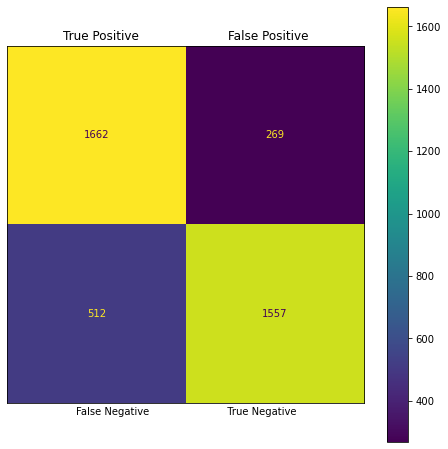

In [42]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .20, random_state = 100)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
        # Instantiate model 
rf = RandomForestClassifier()

        # Train the model on training data
rf.fit(X_train, y_train);

        # Use the forest's predict method on the test data
predictions = rf.predict(X_test)

        # Calculate the absolute errors
errors = abs(predictions - y_test)

        # Print out the mean absolute error (mae)
print('Average model error:', round(np.mean(errors), 2), 'degrees.')


        # Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / predictions)

        # Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print(classification_report(y_test, predictions))
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(estimator=rf, X=X_test, y_true=y_test, ax=ax)
plt.title('True Positive                       False Positive')
plt.xlabel('False Negative                         True Negative')
plt.ylabel('')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

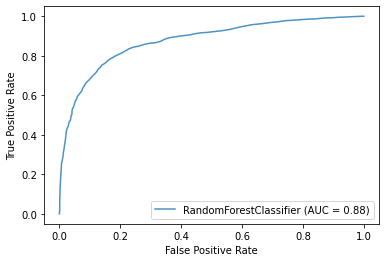

In [43]:

ax = plt.gca()
rfc_disp = plot_roc_curve(rf, X_test, y_test, ax=ax, alpha=0.8)

plt.show()
# from sklearn.metrics import roc_auc_score
# fpr, tpr, thresholds = roc_curve(y, predictions)

The AUC is naturally at a .88 out of a 1 so thats a very good score. This means that out of all the data that 88% of the data gets correctly categorized as a true positive and a true negative.

## Hyper-tuning Model:

Now that I have a base model classified I will be working on trying to see if I can get that accuracy up higher from where it was at at the start of the base of 81%. With that we will be using RandomizedSearchCV.

In [45]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features, 
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train, y_train)
# print results
print(rfc_random.best_params_)

In [46]:
# param_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}


# grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
#                           cv = 3, n_jobs = -1, verbose = 2)
# grid_search.fit(X_train, y_train)
# grid_search.best_params_

In [50]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rfc_random.best_estimator_
random_eval = evaluate(best_random, X_test, y_test)

In [ ]:
# best_grid = grid_search.best_estimator_
# grid_eval = evaluate(best_grid, X_test, y_test)

## Modified Random Forest
 It had a really good prediction rate at an 83% prediction. I also noticed that two random columns were added in as well so I went ahead and removed those as well. Prior to removing all the columns I was at a 76% prediction rate. After removing the columns it jumped up to a 82% prediction rate, which is pretty good.

<IPython.core.display.Javascript object>

Average model error: 0.19 degrees.


<IPython.core.display.Javascript object>

Accuracy: -inf %.
              precision    recall  f1-score   support

         0.0       0.77      0.86      0.81      1931
         1.0       0.85      0.77      0.81      2069

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

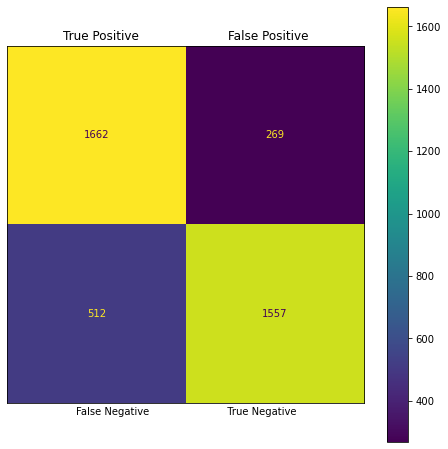

In [51]:


X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = .20, random_state = 100)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
        # Instantiate model
rf2 = RandomForestClassifier(n_estimators= 400, min_samples_split = 5, min_samples_leaf =  1, max_features = 'auto', max_depth = 90, bootstrap = False)

        # Train the model on training data
rf2.fit(X_train, y_train);

        # Use the forest's predict method on the test data
predictions = rf2.predict(X_test)

        # Calculate the absolute errors
errors = abs(predictions - y_test)

        # Print out the mean absolute error (mae)
print('Average model error:', round(np.mean(errors), 2), 'degrees.')


        # Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / predictions)

        # Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')
print(classification_report(y_test, predictions))
fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(estimator=rf, X=X_test, y_true=y_test, ax=ax)
plt.title('True Positive                       False Positive')
plt.xlabel('False Negative                         True Negative')
plt.ylabel('')
plt.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
plt.show()
to_remove = []



In [52]:
# import scipy
# from scipy.cluster import hierarchy as hc
# corr = np.round(scipy.stats.spearmanr(dataset).correlation, 4)
# corr_condensed = hc.distance.squareform(1-corr)
# z = hc.linkage(corr_condensed, method='average')
# fig = plt.figure(figsize=(20,20))
# dendrogram = hc.dendrogram(z, labels=dataset.columns,
#     orientation='left', leaf_font_size=16)
# plt.show()

# Interpretations
What the data says about the question:
- Is the crash caused by a negligent driver or is it caused by actions that were not contributed to the driver. IE driving while using phone, faulty car/animals etc

Taking a look at the initial model and the hyper-tuned model shows that even though the accuracy went up by 1 percent that the AUC went up. Which tells me that the overall accuracy of the data went up and the classifier was better able to determine the correct categories the data was suppose to go in.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='importance', ylabel='feature'>

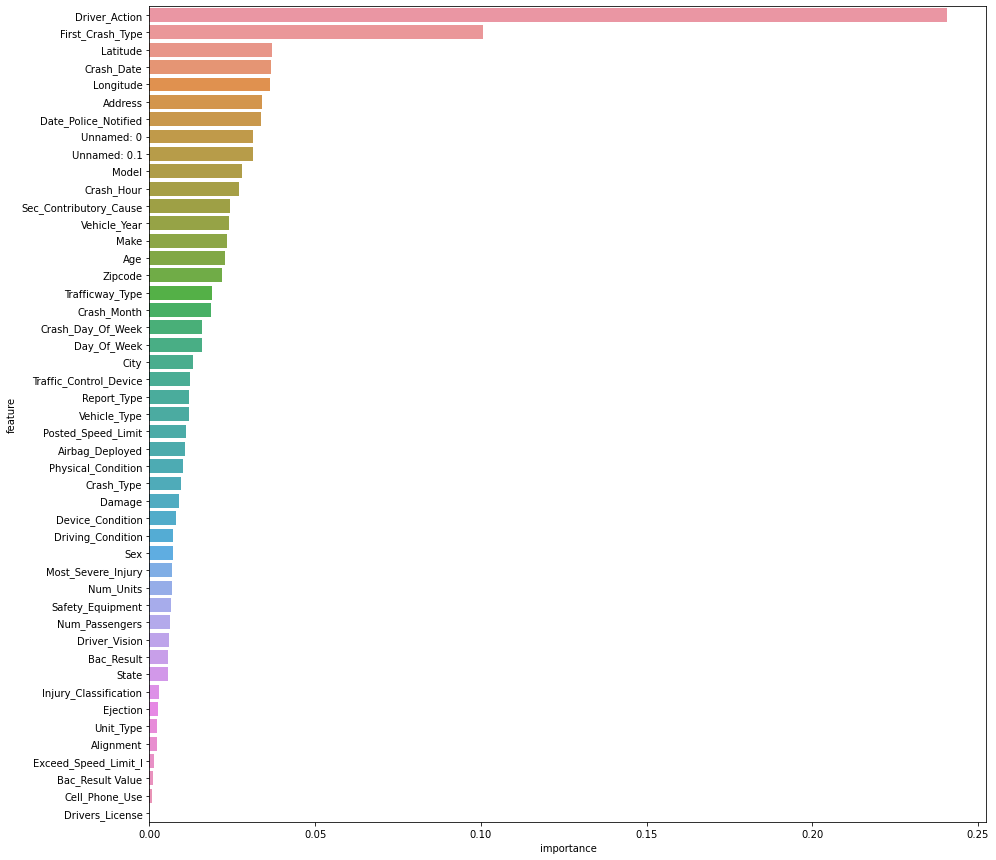

In [53]:
Initial=pd.DataFrame({"feature":X.columns,"importance":rf.feature_importances_})
Initial.sort_values("importance", ascending = False, inplace = True)
fig = plt.figure(figsize= (15,15))
sns.barplot(x ='importance',y = 'feature',data = Initial)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='importance', ylabel='feature'>

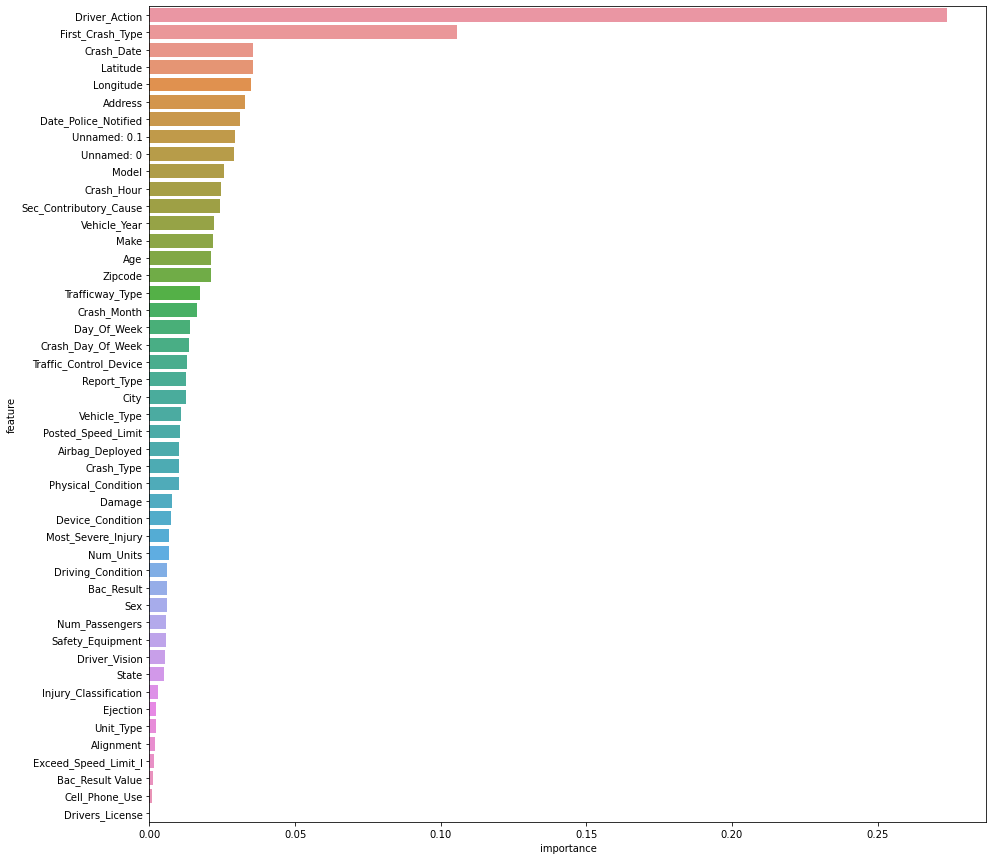

In [54]:
Modified=pd.DataFrame({"feature":X.columns,"importance":rf2.feature_importances_})
Modified.sort_values("importance",ascending = False, inplace = True)
fig = plt.figure(figsize= (15,15))
sns.barplot(x ='importance',y = 'feature',data = Modified)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Initial Models feature importance')

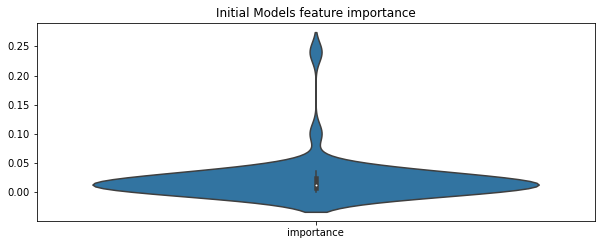

In [55]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(212)
sns.violinplot(data=Initial, ax=ax)
plt.title('Initial Models feature importance')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Hypertuned Models feature importance')

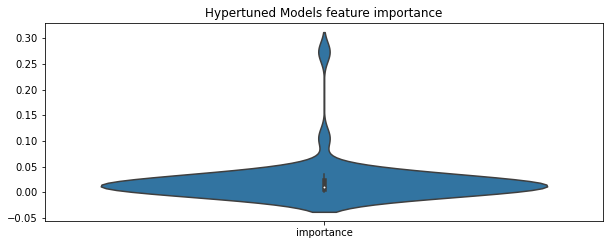

In [56]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(211)
sns.violinplot(data=Modified, ax=ax)
plt.title('Hypertuned Models feature importance')
